## Preparación del ambiente de Trabajo

In [3]:
!pip install ipython-autotime;
%load_ext autotime
%pip install darts;

import warnings
warnings.filterwarnings('ignore')

#libraries' installation
import pandas as pd
import numpy as np

import scipy.stats as stats
from scipy.stats import normaltest
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from darts import TimeSeries
#from darts.dataprocessing.transformers import MissingValuesFiller
from darts.metrics.metrics import mape, mae
from darts import concatenate
from darts.models.forecasting.arima import ARIMA
from darts.utils.statistics import extract_trend_and_seasonality, remove_from_series, stationarity_test_adf
from darts.utils.utils import ModelMode
from darts.utils.model_selection import train_test_split

time: 58.1 s (started: 2022-09-20 21:37:43 -03:00)


### Data ingestion

The company gave the following information:
1. Sales: sales of every product, in kilograms, sorted by date
2. Items: the description of the selected products for the project
3. Vendors ('Vendedores'): information about the vendors at the teleshopping channel
4. Temperature ('Temperatura'): the first additional information added to the models was the temperature of the day of the sell. The information was taken of the Chilean Meteorological Direction (http://www.meteochile.gob.cl) of the Metropolitan Region, at the Quinta Normal Station (average temperature of the day).

In [6]:
path_items = 'items.csv'
path_sales = 'salesfact.csv'
path_salesperson = 'vendedores.csv'
path_extra = 'temperatura.csv'

df_items = pd.read_csv(path_items)
df_sales = pd.read_csv(path_sales)
df_salesperson = pd.read_csv(path_salesperson)
df_temperature = pd.read_csv(path_extra)

random_seed = 3748

time: 156 ms (started: 2022-09-20 21:50:46 -03:00)


The information of the weight of the products had variations, that were corrected in the column 'Format' ('Formato').

In [7]:
df = df_sales
df['Formato'] = np.where(df['Descripción del artículo'].str.find("200 Gr")+df['Descripción del artículo'].str.find("200Gr")>=0,"200 Gr",
                np.where(df['Descripción del artículo'].str.find("1 Kg")+df['Descripción del artículo'].str.find("1Kg")>=0,"1000 Gr",
                np.where(df['Descripción del artículo'].str.find("5 Kg")+df['Descripción del artículo'].str.find("5Kg")>=0,"5000 Gr","Otro")))
df.Formato.unique()

array(['5000 Gr', '1000 Gr', '200 Gr'], dtype=object)

time: 141 ms (started: 2022-09-20 21:50:52 -03:00)


### Columns re-codification

It will be made an analysis of the information at the Sales and Items tables, and after, the names will be changed, and the columns with information that won't be used, will be dropped.

In [8]:
print('Productos')
print(df_items.columns)
print('Ventas')
print(df_sales.columns)
print('Vendedores')
print(df_salesperson.columns)

Productos
Index(['Familia', 'Peso ( Kg )', 'InventoryUoMName',
       'InventoryValuationMethod_E', 'Es artículo de Inventario',
       'Es artículo de compras', 'Es artículo de ventas', 'ItemCode',
       'ItemDescriptionAndCode', 'Descripción del artículo', 'ItemGroupName',
       'El articulo esta activo', 'Sub - Familia'],
      dtype='object')
Ventas
Index(['Cantidad (en UM de inventario)', 'VentaNeta', 'CodCliente',
       'Número de documento', 'ItemCode', 'CodVendedor',
       'Código de almacén de línea', 'Fecha', 'Descripción del artículo',
       'CanalDeVenta', 'Kilombos', 'Formato'],
      dtype='object')
Vendedores
Index(['Active', 'Locked', 'Codigo Vendedor', 'Nombre Vendedor'], dtype='object')
time: 0 ns (started: 2022-09-20 21:50:58 -03:00)


In the <code>Items</code> table, the columns '<code>Weight</code>' ('<code>Peso</code>') and '<code>The product is active</code>' ('<code>El articulo esta activo</code>') because:
1. The weight will be used for adding the rows to grouping the sells, for every kind of product
2. The product category will be used for filtering the <code>Items</code> table

In [9]:
df_items.drop(columns = ["Familia",
                         "InventoryUoMName",
                         "InventoryValuationMethod_E",
                         "Es artículo de Inventario",
                         "Es artículo de compras",
                         "Es artículo de ventas",
                         "ItemDescriptionAndCode",
                         "ItemGroupName",
                         "Sub - Familia"],
              inplace = True)

df_sales.drop(columns = ["Cantidad (en UM de inventario)",
                         "Código de almacén de línea",
                         "ItemCode",
                         "CanalDeVenta"],
              inplace = True)

df_salesperson.drop(columns = ["Active",
                               "Locked",
                               "Nombre Vendedor"],
                    inplace = True)

time: 16 ms (started: 2022-09-20 21:51:02 -03:00)


In [10]:
print('Productos')
print(df_items.columns)
print('Ventas')
print(df_sales.columns)
print('Vendedores')
print(df_salesperson.columns)

Productos
Index(['Peso ( Kg )', 'ItemCode', 'Descripción del artículo',
       'El articulo esta activo'],
      dtype='object')
Ventas
Index(['VentaNeta', 'CodCliente', 'Número de documento', 'CodVendedor',
       'Fecha', 'Descripción del artículo', 'Kilombos', 'Formato'],
      dtype='object')
Vendedores
Index(['Codigo Vendedor'], dtype='object')
time: 0 ns (started: 2022-09-20 21:51:06 -03:00)


Now, it will be analyzed the active products filtering the table <code>Items</code> by the category <code>El articulo esta activo</code> with the positive answer, <code>Y</code>.

In [11]:
df_items = df_items[df_items['El articulo esta activo'] == 'Y']
df_items.drop(columns = ['El articulo esta activo'],inplace = True)
df_items

time: 16 ms (started: 2022-09-20 21:51:09 -03:00)


The rest of the columns will be renamed, and the previous dataframes will be replaced.

In [13]:
def refactor(cols, df):
    newDf = df.copy()
    newDf.rename(columns = cols, inplace = True)
    return newDf

df_sales = refactor({
    'VentaNeta' : 'venta_neta',
    'CodCliente' : 'cod_cliente',
    'Número de documento' : 'num_documento',
    'Descripción del artículo' : 'description',
    'CodVendedor' : 'cod_vendedor',
    'Fecha' : 'fecha',
    'Kilombos' : 'kilos'
    }, df_sales)
df_items = refactor({
    'Peso ( Kg )' : 'peso',
    'ItemCode' : 'item_code',
    'Descripción del artículo' : 'description',
    }, df_items)
df_salesperson = refactor({'Codigo Vendedor' : 'codigo_vendedor'}, df_salesperson)
df_temperature = refactor({'Fecha' : 'fecha', 'Temperatura media Cº' : 'temperatura_media'}, df_temperature)

time: 0 ns (started: 2022-09-21 16:28:36 -03:00)


### Descriptions anonymization

It will be checked all the descriptions of the products in the <code>Items</code> table effectively are at the <code>Sales</code> table.

In [14]:
items = np.unique(df_items['description'])
sales = np.unique(df_sales['description'])

registro_encontrado = []
registro_no_encontrado = []
for i in sales:
  if i in items:
    registro_encontrado.append(i)
  else:
    registro_no_encontrado.append(i)

print('Cantidad de Productos no encontrados')
print(len(registro_no_encontrado))

Productos no encontrados
['Almendra Cubiertas Con Chocolate Bitter Bl 1 Kg.', 'Almendras Cubiertas Con Chocolate De Leche Bl 1 Kg', 'Cranberry Entero  Cubierta Chocolate Bitter Bl. 1Kg', 'Mani Cubierta Chocolate Leche Bl. 1Kg.']
time: 15 ms (started: 2022-09-21 16:28:40 -03:00)


There are 4 kinds of products that don't have registered sells. For that reason, the <code>Items</code> table doesn't give precise information about the products, therefore, it won't be used for the analysis, and the different categories will be taken of the description of the <code>Sales</code> table. The information in that column will be reviewed and renamed.

Note:
1. The dictionary <code>sales_description_dict</code> has created keys for hidding the original ones.

In [15]:
df_sales.head(10)

,venta_neta,cod_cliente,num_documento,cod_vendedor,fecha,description,kilos,Formato
0,82530.0,C9233798,1017811,95,1-Apr-19,Almendra Cubiertas Con Chocolate Bitter Cj 5 Kg.,10.0,5000 Gr
1,254117.0,C76658352,1017839,4,2-Apr-19,Cranberry Cubierta Chocolate Leche Bl. 5Kg,40.0,5000 Gr
2,30252.0,C13479118,1018354,4,5-Apr-19,Mani Cubierta Chocolate Leche Bl. 5Kg,5.0,5000 Gr
3,35294.0,C13479118,1018354,4,5-Apr-19,Cranberry Cubierta Chocolate Leche Bl. 5Kg,5.0,5000 Gr
4,40757.0,C13479118,1018354,4,5-Apr-19,Almendras Cubiertas Con Chocolate De Leche Bl ...,5.0,5000 Gr
5,30672.0,C76990508,1018362,11,25-Apr-19,Mani Cubierta Chocolate Bitter Bl. 5Kg,5.0,5000 Gr
6,40756.0,C76900817,1018361,11,25-Apr-19,Almendras Cubiertas Con Chocolate De Leche Bl ...,5.0,5000 Gr
7,41176.0,C15257846,1018360,11,25-Apr-19,Almendra Cubiertas Con Chocolate Bitter Cj 5 Kg.,5.0,5000 Gr
8,41177.0,C76990508,1018362,11,25-Apr-19,Almendra Cubiertas Con Chocolate Bitter Cj 5 Kg.,5.0,5000 Gr
9,35714.0,C9757137,1018425,11,30-Apr-19,Cranberry Entero Cubierta Chocolate Bitter Bl...,5.0,5000 Gr


time: 47 ms (started: 2022-09-21 16:28:45 -03:00)


In [16]:
#borrar antes de subir con resultados
sales_description_dict = {
    "Almendra Cubierta Con Chocolate Bitter Bl 200Gr." : "AB1", 
    "Almendra Cubierta Con Chocolate De Leche Bl 200Gr." : "AL1",
    "Almendra Cubiertas Con Chocolate Bitter Bl 1 Kg." : "AB2",
    "Almendra Cubiertas Con Chocolate Bitter Cj 5 Kg." : "AB3",
    "Almendras Cubiertas Con Chocolate De Leche Bl 1 Kg" : "AL2",
    "Almendras Cubiertas Con Chocolate De Leche Bl 5 Kg" : "AL3",
    "Cranberry Cubierta Chocolate Leche Bl. 200 Gr." : "CL1",
    "Cranberry Cubierta Chocolate Leche Bl. 5Kg" : "CL3",
    "Cranberry Entero  Cubierta Chocolate Bitter Bl. 1Kg" : "CB2",
    "Cranberry Entero  Cubierta Chocolate Bitter Bl. 5Kg" : "CB3",
    "Cranberry Entero  Cubierta Chocolate Bitter Bl.200 Gr." : "CB1",
    "Mani Cubierta Chocolate Bitter Bl. 200Gr." : "MB1",
    "Mani Cubierta Chocolate Bitter Bl. 5Kg" : "MB3",
    "Mani Cubierta Chocolate Leche Bl. 1Kg." : "ML2",
    "Mani Cubierta Chocolate Leche Bl. 200Gr." : "ML1",
    "Mani Cubierta Chocolate Leche Bl. 5Kg" : "ML3"
}

#for example purposes I created this dict.
#Note: the category 'CL2' and 'MB2' were omitted because the weight of the products effectively sold (the categories exist in the Items table but there's no register of sells)

sales_description_dict_example = {
    "product1_type1" : "AB1", 
    "product2_type1" : "AL1",
    "product1_type2" : "AB2",
    "product1_type3" : "AB3",
    "product2_type2" : "AL2",
    "product2_type3" : "AL3",
    "product3_type1" : "CL1",
    "product2_type3" : "CL3",
    "product3_type2" : "CB2",
    "product3_type3" : "CB3",
    "product3_type1" : "CB1",
    "product4_type1" : "MB1",
    "product4_type3" : "MB3",
    "product5_type2" : "ML2",
    "product5_type1" : "ML1",
    "product5_type3" : "ML3"
}

df_sales['description'] = df_sales['description'].replace(sales_description_dict)

df_sales['grupo'] = df_sales['description'].apply(lambda x: x[0:2])

print('Productos', df_sales['description'].unique())
print('Grupos', df_sales['grupo'].unique())

Productos ['AB3' 'CL3' 'ML3' 'AL3' 'MB3' 'CB3' 'AL2' 'AB1' 'ML1' 'MB1' 'CL1' 'AL1'
 'CB1' 'ML2' 'AB2' 'CB2']
Grupos ['AB' 'CL' 'ML' 'AL' 'MB' 'CB']
time: 31 ms (started: 2022-09-21 16:28:48 -03:00)


### Re-codification of time attribute

The column with the date of the sell ('<code>fecha</code>') will be converted to datetime. It will be used 2 criterias for categorizing time:

1. Weekly
2. Monthly

After, the datatypes will be changed.

In [17]:
df_sales['ds'] = df_sales['fecha'].apply(lambda date: pd.to_datetime(date, format='%d-%b-%y')).sort_values(ascending=True)
df_sales['ds-monthYear'] = df_sales['ds'].dt.strftime('%Y-%m')
df_sales['ds-weekYear'] = df_sales['ds'].dt.strftime('%Y-%U')
df_sales.drop(columns = ['fecha'],
              inplace = True)

time: 5.25 s (started: 2022-09-21 16:28:53 -03:00)


In [18]:
df_sales.venta_neta.astype('float64')
df_sales.cod_cliente.astype('str')
df_sales.num_documento.astype('int32')
df_sales.cod_vendedor.astype('int32')
df_sales.description.astype('str')
df_sales.kilos.astype('float64')
df_temperature.fecha = pd.to_datetime(df_temperature['fecha'], format = '%d/%m/%Y')
df_temperature.temperatura_media.astype('float64');

time: 32 ms (started: 2022-09-21 16:29:12 -03:00)


In [19]:
df_sales.dtypes

venta_neta              float64
cod_cliente              object
num_documento             int64
cod_vendedor              int64
description              object
kilos                   float64
Formato                  object
grupo                    object
ds               datetime64[ns]
ds-monthYear             object
ds-weekYear              object
dtype: object

time: 16 ms (started: 2022-09-21 16:29:15 -03:00)


In [20]:
df_temperature.dtypes

fecha                datetime64[ns]
temperatura_media           float64
dtype: object

time: 16 ms (started: 2022-09-21 16:29:17 -03:00)


### Anomaly detection

First, the groups of products will be checked to see the amount of sales of each one.

In [21]:
df_sales.groupby(['description']).size()

description
AB1     113
AB2       1
AB3    1196
AL1      91
AL2       1
AL3     844
CB1     119
CB2       1
CB3    1481
CL1      83
CL3     743
MB1      94
MB3     991
ML1      97
ML2       1
ML3     842
dtype: int64

time: 15 ms (started: 2022-09-21 16:29:21 -03:00)


There are 4 products with just 1 sell. For that reason, those products will be dropped from the dataframe.

In [22]:
df_clean = df_sales[~df_sales['description'].isin(['AL2', 'AB2', 'ML2', 'CB2'])]
df_clean.groupby(['description']).size()

description
AB1     113
AB3    1196
AL1      91
AL3     844
CB1     119
CB3    1481
CL1      83
CL3     743
MB1      94
MB3     991
ML1      97
ML3     842
dtype: int64

time: 31 ms (started: 2022-09-21 16:29:24 -03:00)


#### Invoice cancellations

There are sells with negative weight, because they are cancellations of previous sells, of a part or the total sold. The criteria chosen by the team was to preserve that information in the dataframe.

In [23]:
df_sales_cancelled = df_clean[df_clean['kilos'] < 0]
print('Anulaciones', '\nCantidad de anulaciones:', df_sales_cancelled.shape[0], '\nCantidad de num_documento de anulaciones (operaciones por comprador): ', len(np.unique(df_sales_cancelled['num_documento'])))
print(df_sales_cancelled['kilos'].describe())
print('Suma de kilos devueltos: ', df_sales_cancelled['kilos'].sum())

Anulaciones 
Cantidad de anulaciones: 103 
Cantidad de num_documento de anulaciones (operaciones por comprador):  52
count    103.000000
mean     -11.209709
std       17.111088
min     -100.000000
25%      -10.000000
50%       -5.000000
75%       -5.000000
max       -0.200000
Name: kilos, dtype: float64
Suma de kilos devueltos:  -1154.6
time: 31 ms (started: 2022-09-21 16:29:26 -03:00)


#### Outliers

For the identification of the outliers, it will be used the average and monthly standard deviation of all the products. An analysis of 1, 2, 5 and 7 std will be made (around the average). After, there will be some graphics to check the outliers for every criteria in an easier way.

In [24]:
df_sales_weekly = df_clean.groupby(['ds-monthYear']).agg({'kilos' : ['mean', 'std']})
df_sales_weekly.columns = ['mean', 'std']
df_sales_weekly.reset_index(inplace = True)

weeks = {}
for i, series in df_sales_weekly.iterrows():
    if(series['ds-monthYear'] not in weeks.keys()):
        weeks[series['ds-monthYear']] = {}
    weeks[series['ds-monthYear']] = {
        'mean' : series['mean'],
        'std' : series['std']
    }

def checkOutlier(x, mean, std, steps):
    if(x > mean + steps * std or x < mean - steps * std):
        return 1
    else:
        return 0

for i, row in df_clean.iterrows():
    mean = weeks[row['ds-monthYear']]['mean']
    std = weeks[row['ds-monthYear']]['std']
    if row['ds-monthYear'] in weeks:
        df_clean.at[i, 'outlier-1'] = checkOutlier(row['kilos'], mean, std, 1)
        df_clean.at[i, 'outlier-2'] = checkOutlier(row['kilos'], mean, std, 2)
        df_clean.at[i, 'outlier-5'] = checkOutlier(row['kilos'], mean, std, 5)
        df_clean.at[i, 'outlier-7'] = checkOutlier(row['kilos'], mean, std, 7)
    else:
        print('Semana no encontrada', row['ds-monthYear'])
        df_clean.at[i, 'outlier-1'] = 1
        df_clean.at[i, 'outlier-2'] = 1
        df_clean.at[i, 'outlier-5'] = 1
        df_clean.at[i, 'outlier-7'] = 1

time: 4.2 s (started: 2022-09-21 16:29:30 -03:00)


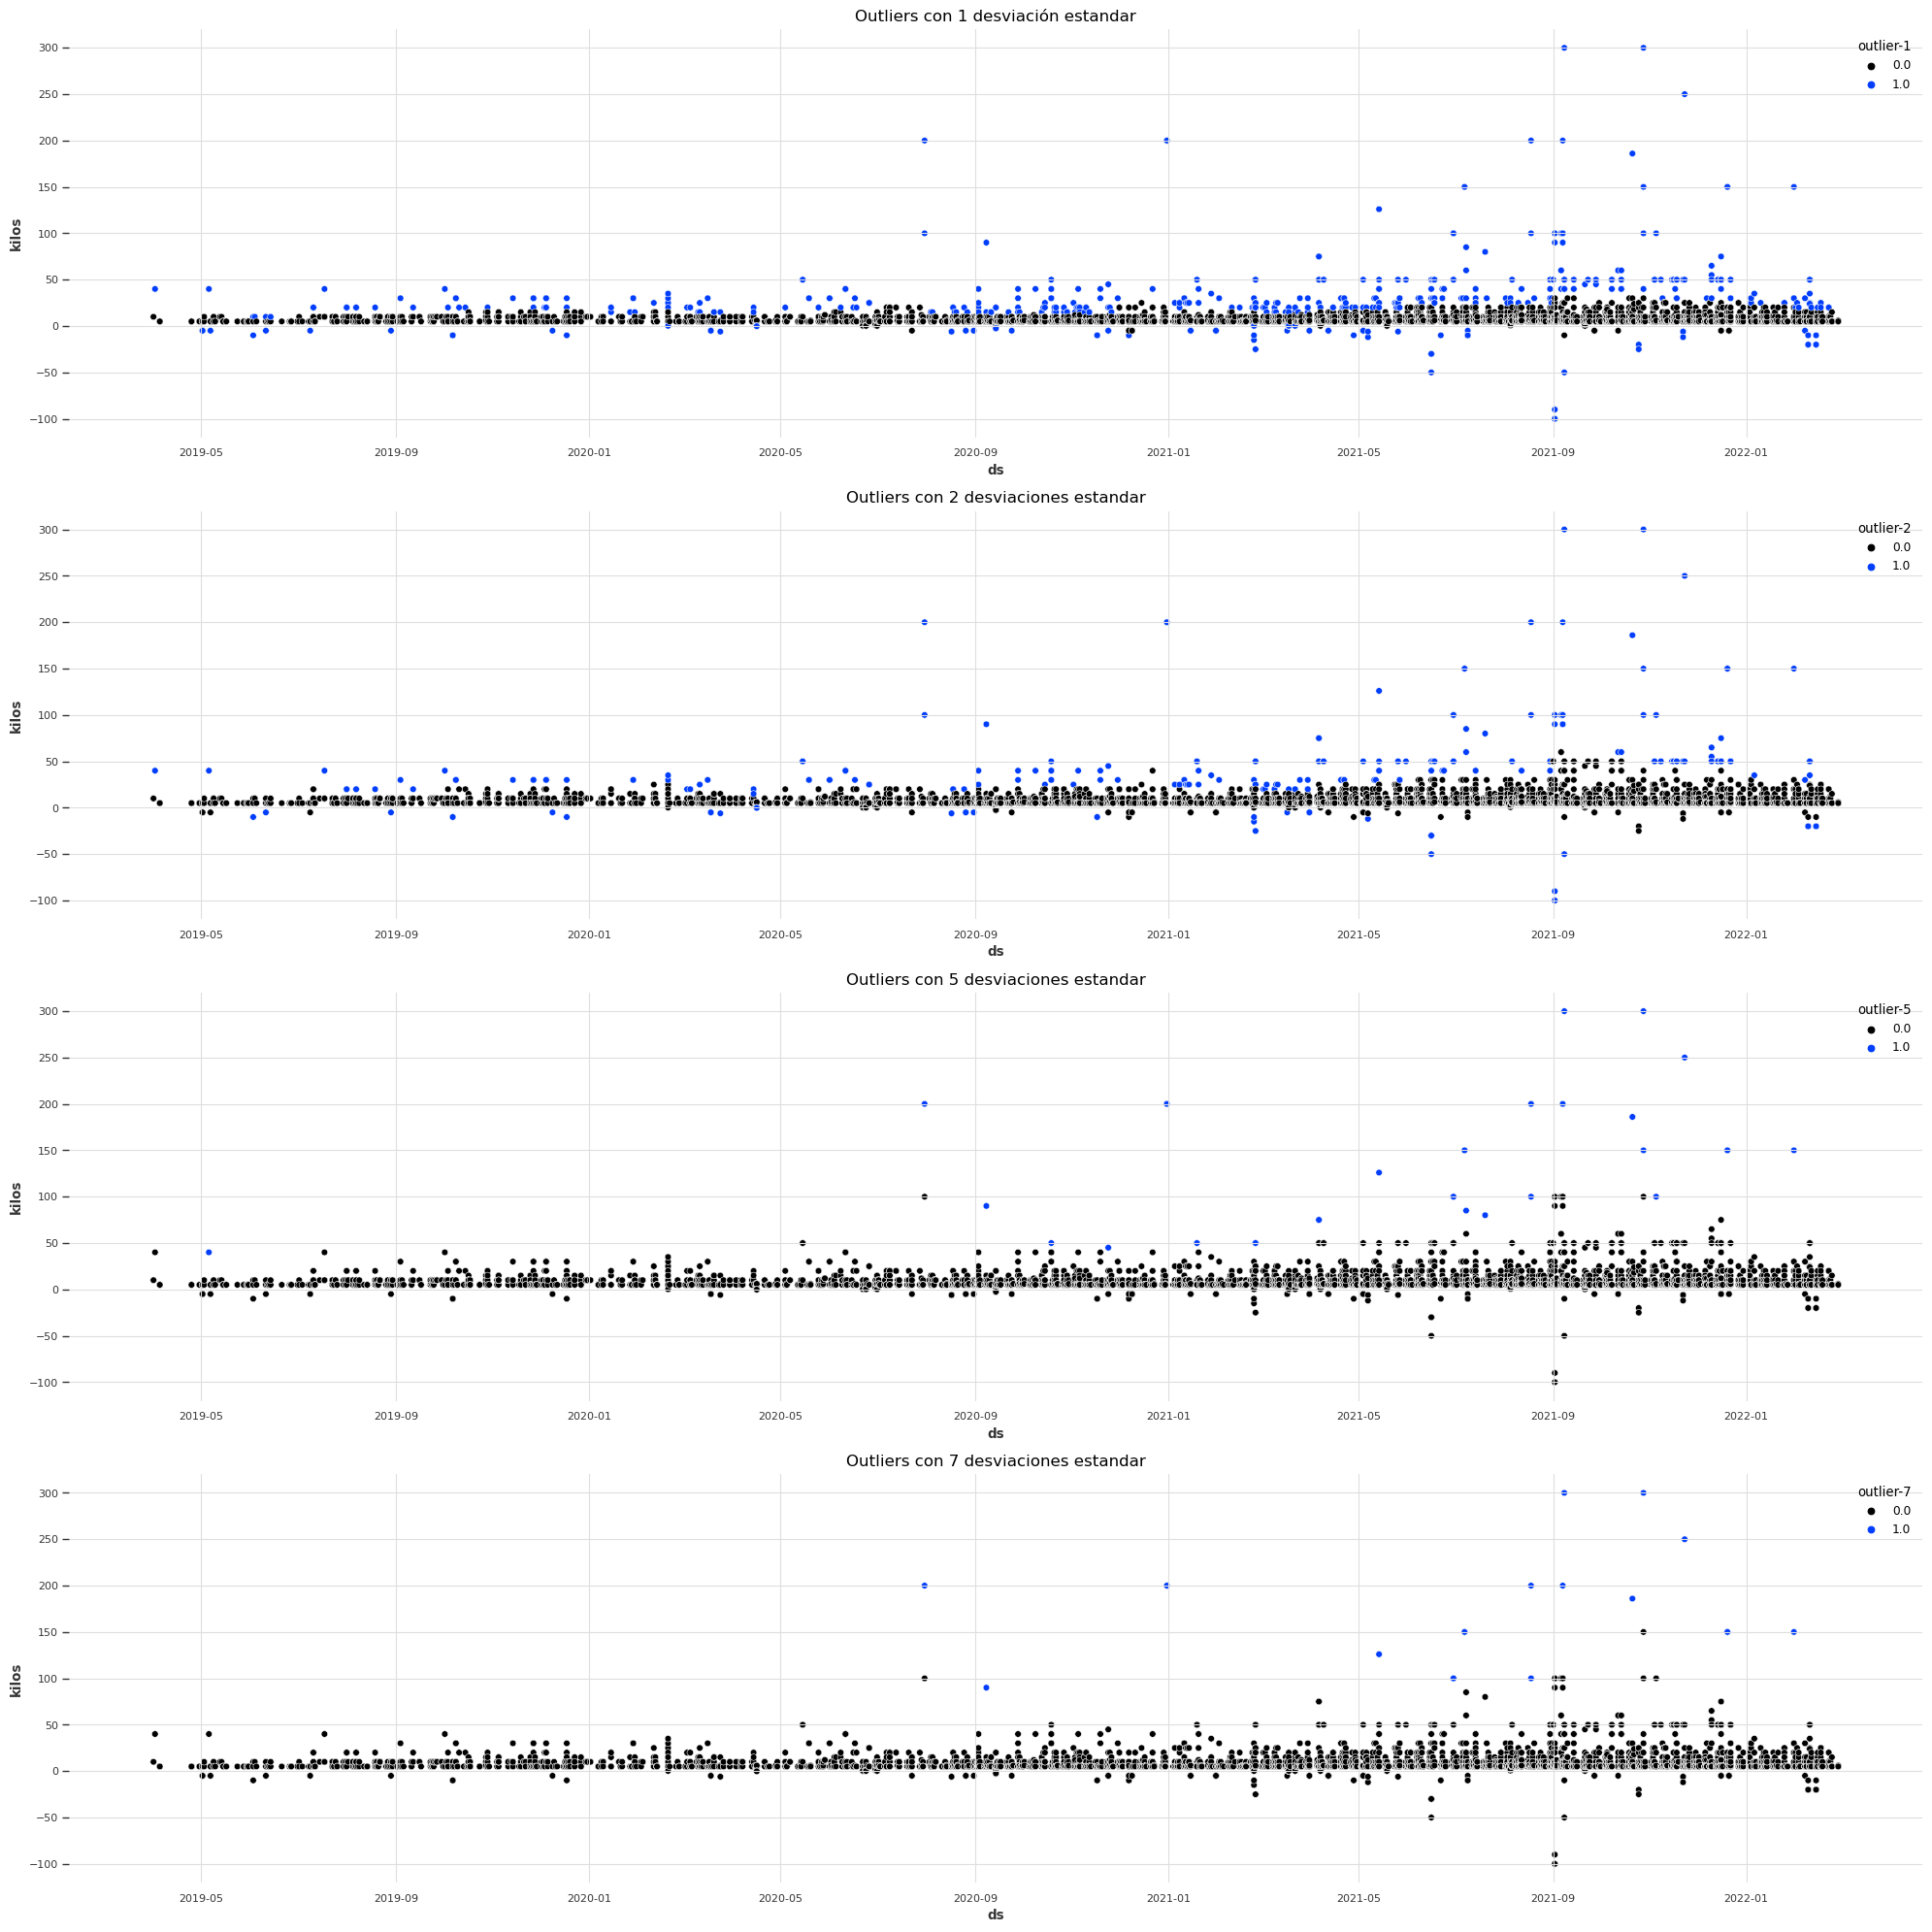

time: 8.72 s (started: 2022-09-21 16:29:59 -03:00)


In [25]:
fig, ax = plt.subplots(4, 1,figsize=(20,20))
sns.scatterplot(df_clean['ds'], df_clean['kilos'], hue = df_clean['outlier-1'], ax=ax[0])
ax[0].set_title('Outliers con 1 desviación estandar', fontsize=12)
sns.scatterplot(df_clean['ds'], df_clean['kilos'], hue = df_clean['outlier-2'], ax=ax[1])
ax[1].set_title('Outliers con 2 desviaciones estandar', fontsize=12)
sns.scatterplot(df_clean['ds'], df_clean['kilos'], hue = df_clean['outlier-5'], ax=ax[2])
ax[2].set_title('Outliers con 5 desviaciones estandar', fontsize=12)
sns.scatterplot(df_clean['ds'], df_clean['kilos'], hue = df_clean['outlier-7'], ax=ax[3])
ax[3].set_title('Outliers con 7 desviaciones estandar', fontsize=12)
plt.tight_layout()

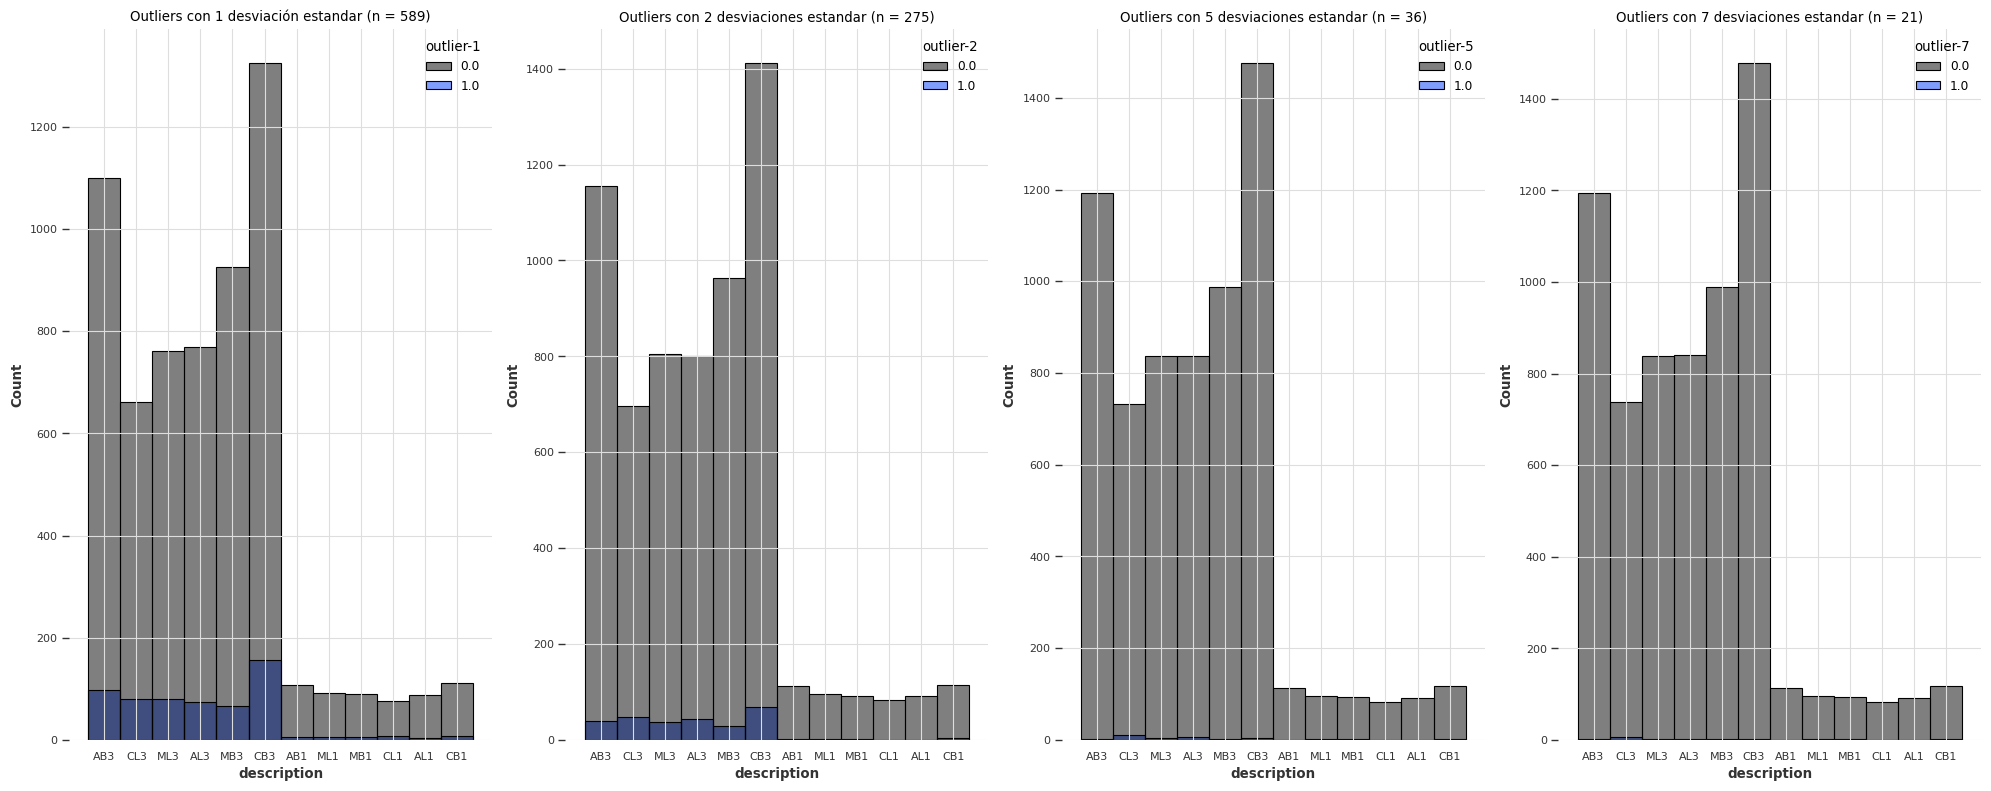

time: 4.83 s (started: 2022-09-21 16:30:15 -03:00)


In [26]:
fig, ax = plt.subplots(1, 4,figsize=(20,8))
sns.histplot(data=df_clean, x='description', hue='outlier-1', ax=ax[0])
ax[0].set_title(f'Outliers con 1 desviación estandar (n = {df_clean[df_clean["outlier-1"] == 1].shape[0]})')
sns.histplot(data=df_clean, x='description', hue='outlier-2', ax=ax[1])
ax[1].set_title(f'Outliers con 2 desviaciones estandar (n = {df_clean[df_clean["outlier-2"] == 1].shape[0]})')
sns.histplot(data=df_clean, x='description', hue='outlier-5', ax=ax[2])
ax[2].set_title(f'Outliers con 5 desviaciones estandar (n = {df_clean[df_clean["outlier-5"] == 1].shape[0]})')
sns.histplot(data=df_clean, x='description', hue='outlier-7', ax=ax[3])
ax[3].set_title(f'Outliers con 7 desviaciones estandar (n = {df_clean[df_clean["outlier-7"] == 1].shape[0]})')
plt.tight_layout()

After the analysis, the team decided to use the last criteria for outliers filtering (7 standard deviations).

In [27]:
df_clean['outlier-7'].value_counts()

0.0    6673
1.0      21
Name: outlier-7, dtype: int64

time: 15 ms (started: 2022-09-21 16:30:23 -03:00)


In [28]:
df_clean_outliers = df_clean[df_clean['outlier-7'] == 0]

time: 15 ms (started: 2022-09-21 16:30:26 -03:00)


#### Data filtering

Because of the changes at a general level, in the patterns of shopping during the Covid-19 emergency, the team decided to take only the information from febrary-2020 onwards. February is considered for expanding the window for the PACF analysis.

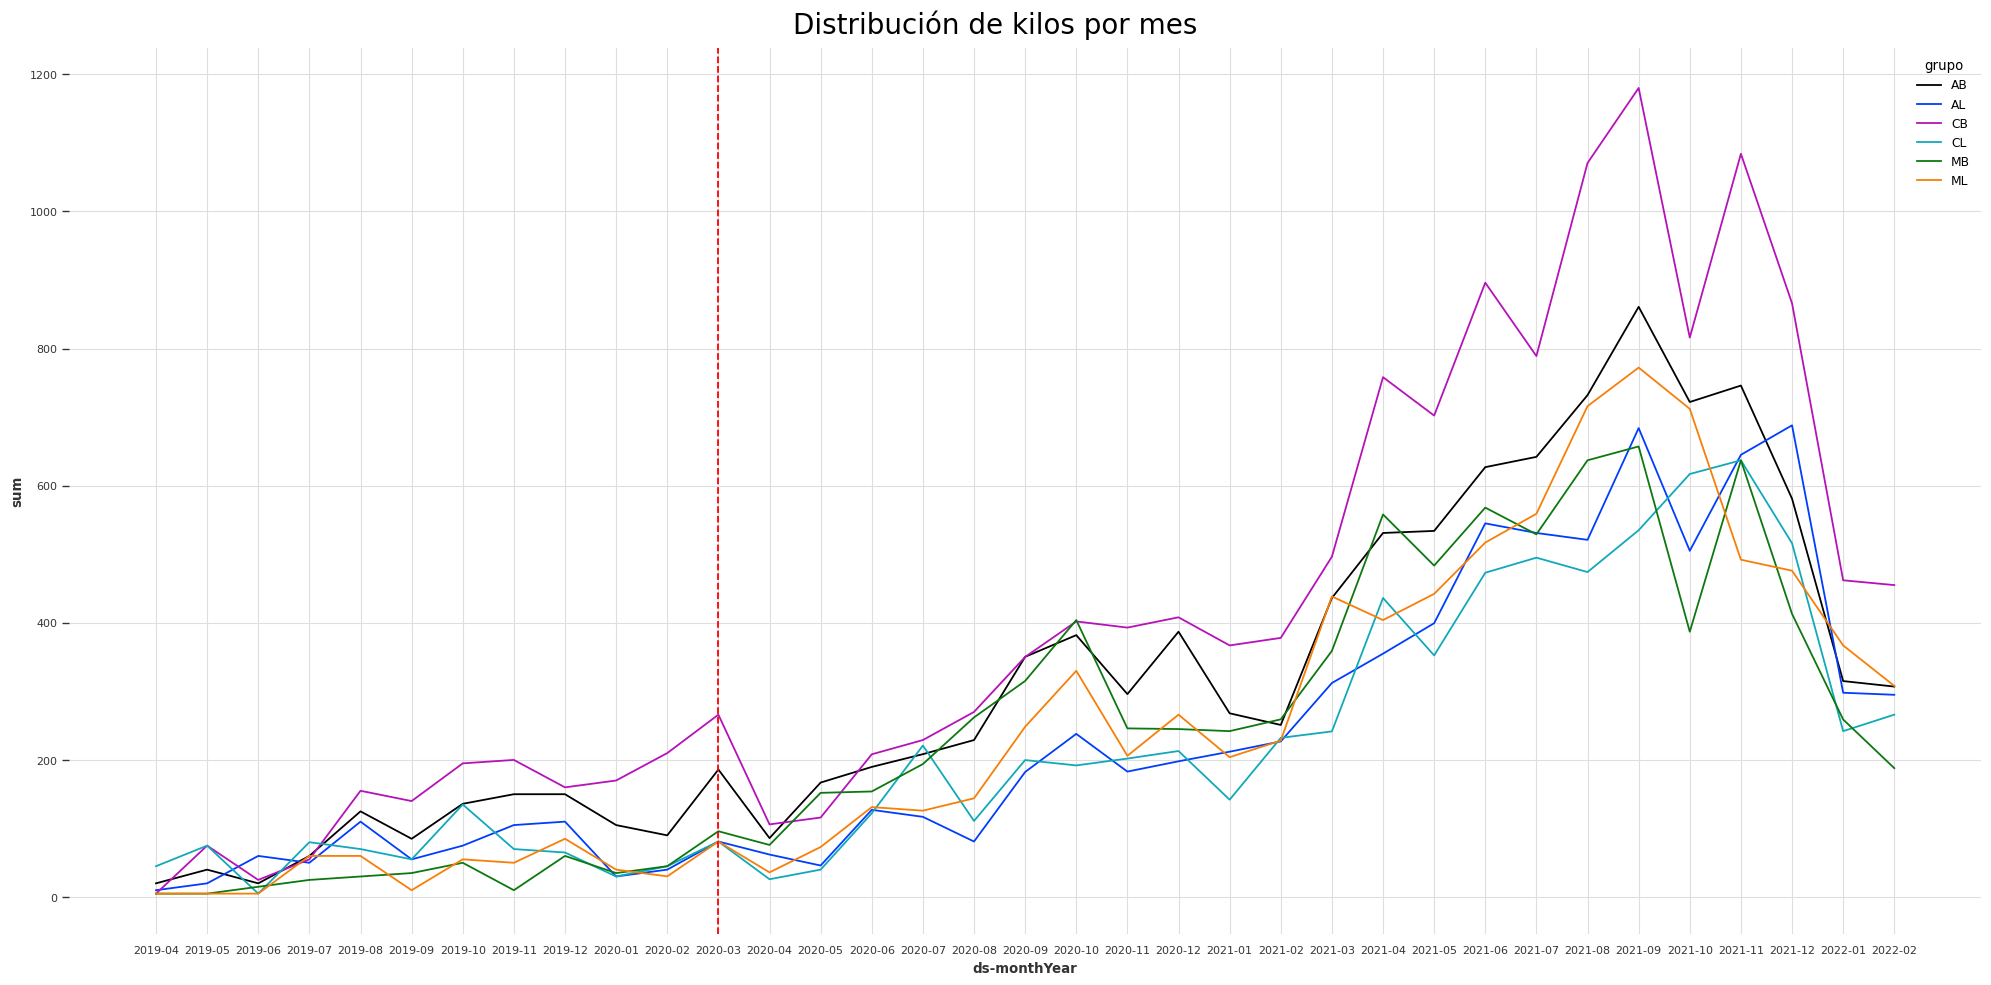

time: 3.3 s (started: 2022-09-21 16:30:29 -03:00)


In [29]:
df_grouped_monthly = df_clean_outliers.sort_values(by=['ds']).groupby(['ds-monthYear', 'grupo']).agg({'kilos' : ['sum']})
df_grouped_monthly.columns = ['sum']
df_grouped_monthly.reset_index(inplace = True)
plt.figure(figsize=(20,10))
sns.lineplot(data=df_grouped_monthly, x='ds-monthYear', y='sum', hue='grupo')
plt.suptitle('Distribución de kilos por mes', fontsize=20)
plt.axvline(x='2020-03', color='r', linestyle='--')
plt.tight_layout()

In [30]:
df_clean_outliers = df_clean_outliers[df_clean_outliers['ds'] >= pd.to_datetime('2020-02-01')]

time: 0 ns (started: 2022-09-21 16:30:37 -03:00)


### Grouping

For using the Darts library, the dataframe needs to transform the data to index. Some helpers functions will be made for code processing.

In [31]:
# Function to convert
def convertWeeklyIndex(df):
    cols = [*df.columns, 'month', 'year', 'weekOfYear']
    intDf = pd.DataFrame(columns=cols)

    #from the 13rd week of 2019 to the 48th week of 2021 there are 134 weeks
    año = 2020
    semana = 5 #to include feb-2020
    index = 1
    debugLabels = []
    while True:
        cero = '0' if semana < 10 else ''
        label = f'{año}-{cero}{semana}'
        fecha = pd.to_datetime(f'{label}-6', format='%Y-%U-%w')
        month = fecha.month
        year = fecha.year
        weekOfYear = fecha.strftime('%U')
        if label in df.index:
            intDf.at[index] = [*df.loc[label, :], *[month, year, weekOfYear]]
            debugLabels.append(label)
        else:
            print('weekly No encontrado', label, index)
            intDf.at[index] = [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, month, year, weekOfYear]
        if label == '2022-09':
            break
        index += 1
        semana += 1
        if semana > 52:
            año += 1
            if año == 2020:
                semana = 0
            else:
                semana = 1
    # Create a new dataframe with the dates of the weeks
    newIndex = pd.RangeIndex(0, index)
    try :
        intDf.index = newIndex
    except:
        # Search the index in the dataframe that is not in debugLabels
        notFound = list(filter(lambda x: x not in debugLabels, df.index))
        print(notFound)
    return intDf

# Transformation of the dates of every month to pd.RangeIndex
def convertMonthlyIndex(df):
    cols = [*df.columns, 'month', 'year']
    intDf = pd.DataFrame(columns=cols)
    
    año = 2020
    mes = 2
    index = 1
    debugLabels = []
    while True:
        cero = '0' if mes < 10 else ''
        label = f'{año}-{cero}{mes}'
        if label in df.index:
            intDf.at[index] = [*df.loc[label, :], *[mes, año]]
            debugLabels.append(label)
        else:
            print('monthly No encontrado', label, index)
            intDf.at[index] = [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, mes, año]
        if label == '2022-02':
            break
        index += 1
        mes += 1
        if mes > 12:
            mes = 1
            año += 1
    
    newIndex = pd.RangeIndex(0, index)
    try :
        intDf.index = newIndex
    except:
        notFound = list(filter(lambda x: x not in debugLabels, df.index))
        print(notFound)
    return intDf

time: 16 ms (started: 2022-09-21 16:30:42 -03:00)


In [32]:
# Function which takes a dataframe and returns an object with the data processed in TimeSeries(Darts) format
def preprocessSeries(subDf, freq = 'D', cols = ['kilos_sum', 'kilos_std', 'kilos_max', 'kilos_median']):
    filler = MissingValuesFiller(fill=0.)
    # Creating the instance
    itemTimeSeries = TimeSeries.from_dataframe(subDf, None, value_cols=cols, freq=freq)
    # Completing the missing values
    itemTimeSeries = filler.transform(itemTimeSeries)
    # Separating the data into train and test
    train, test = itemTimeSeries.split_before(0.8)
    # Separating co-variants
    scaled_train_covs = concatenate(
        [
            train['kilos_max'],
            train['kilos_std'],
            train['kilos_median'],
        ],
        axis="component",
    )
    scaled_test_covs = concatenate(
        [
            test['kilos_max'],
            test['kilos_std'],
            test['kilos_median'],
        ],
        axis="component",
    )
    return {
        'df': subDf,
        'series': itemTimeSeries,
        'train': {
            'target': train['kilos_sum'],
            'past_covars': scaled_train_covs,
        },
        'test': {
            'target': test['kilos_sum'],
            'past_covars': scaled_test_covs,
        }
    }

time: 15 ms (started: 2022-09-21 16:30:50 -03:00)


#### Time grouping

The dataset wil be created considering:
1. Time splitting with the whole sales: diary, weekly and monthly grouping
2. Time and product splitting: considering the 6 kinds of products and the same time splitting criteria at the point 1.

In [33]:
# Daily grouping

# Grouping according to date and group
groupedDailyDf = df_clean_outliers.groupby(['ds', 'grupo']).agg({'kilos': ['sum', 'max', 'min', 'mean', 'median', 'std']})
groupedDailyDf.columns = ['_'.join(col).strip() for col in groupedDailyDf.columns.values]
# Create of a dictionary to save the series and get the values for every group
series = {}
for itemCode in groupedDailyDf.index.get_level_values(1).unique():
    subDf = groupedDailyDf[groupedDailyDf.index.get_level_values(1) == itemCode].sort_values(by='ds')
    if(subDf.shape[0] > 1):
        subDf.index = subDf.index.droplevel(1)
        subDf = subDf.astype(float)
        processed_series = preprocessSeries(subDf, freq='D')
        # Adding the data to the dictionary
        series[itemCode] = processed_series
# Getting the totals
groupedTotalDailyDf = df_clean_outliers.groupby(['ds']).agg({'kilos': ['sum', 'max', 'min', 'mean', 'median', 'std']})
groupedTotalDailyDf.columns = ['_'.join(col).strip() for col in groupedTotalDailyDf.columns.values]

groupedDailyDf = groupedTotalDailyDf.astype(float)

series['total'] = preprocessSeries(groupedTotalDailyDf, freq='D')

time: 594 ms (started: 2022-09-21 16:30:55 -03:00)


In [34]:
# Weekly grouping

groupedWeeklyDf = df_clean_outliers.groupby(['ds-weekYear', 'grupo']).agg({'kilos': ['sum', 'max', 'min', 'mean', 'median', 'std']})
groupedWeeklyDf.columns = ['_'.join(col).strip() for col in groupedWeeklyDf.columns.values]

weekly_series = {}
for itemCode in groupedWeeklyDf.index.get_level_values(1).unique():
    subDf = groupedWeeklyDf[groupedWeeklyDf.index.get_level_values(1) == itemCode].sort_values(by='ds-weekYear')
    if(subDf.shape[0] > 1):
        subDf.index = subDf.index.droplevel(1)
        
        subDf = convertWeeklyIndex(subDf).astype(float)
        processed_series = preprocessSeries(subDf, freq='W', cols=['kilos_sum', 'kilos_std', 'kilos_max', 'kilos_median', 'month', 'year', 'weekOfYear'])
        
        weekly_series[itemCode] = processed_series

groupedTotalWeeklyDf = df_clean_outliers.groupby(['ds-weekYear']).agg({'kilos': ['sum', 'max', 'min', 'mean', 'median', 'std']})
groupedTotalWeeklyDf.columns = ['_'.join(col).strip() for col in groupedTotalWeeklyDf.columns.values]

groupedTotalWeeklyDf = convertWeeklyIndex(groupedTotalWeeklyDf).astype(float)

weekly_series['total'] = preprocessSeries(groupedTotalWeeklyDf, freq='W', cols=['kilos_sum', 'kilos_std', 'kilos_max', 'kilos_median', 'month', 'year', 'weekOfYear'])

weekly No encontrado 2020-17 13
weekly No encontrado 2022-09 109
weekly No encontrado 2020-18 14
weekly No encontrado 2020-05 1
weekly No encontrado 2020-08 4
weekly No encontrado 2020-09 5
weekly No encontrado 2020-12 8
weekly No encontrado 2020-14 10
weekly No encontrado 2020-16 12
weekly No encontrado 2022-09 109
weekly No encontrado 2020-05 1
weekly No encontrado 2020-17 13
weekly No encontrado 2022-09 109
weekly No encontrado 2020-05 1
weekly No encontrado 2020-08 4
weekly No encontrado 2020-09 5
weekly No encontrado 2020-14 10
time: 3.91 s (started: 2022-09-21 16:30:57 -03:00)


In [35]:
# Monthly grouping

groupedMonthlyDf = df_clean_outliers.groupby(['ds-monthYear', 'grupo']).agg({'kilos': ['sum', 'max', 'min', 'mean', 'median', 'std']})
groupedMonthlyDf.columns = ['_'.join(col).strip() for col in groupedMonthlyDf.columns.values]
monthly_series = {}
for itemCode in groupedMonthlyDf.index.get_level_values(1).unique():
    subDf = groupedMonthlyDf[groupedMonthlyDf.index.get_level_values(1) == itemCode].sort_values(by='ds-monthYear')
    if(subDf.shape[0] > 1):
        subDf.index = subDf.index.droplevel(1)
        
        subDf = convertMonthlyIndex(subDf).astype(float)
        processed_series = preprocessSeries(subDf, freq='M', cols=['kilos_sum', 'kilos_std', 'kilos_max', 'kilos_median', 'month', 'year'])
        
        monthly_series[itemCode] = processed_series

groupedTotalMonthlyDf = df_clean_outliers.groupby(['ds-monthYear']).agg({'kilos': ['sum', 'max', 'min', 'mean', 'median', 'std']})
groupedTotalMonthlyDf.columns = ['_'.join(col).strip() for col in groupedTotalMonthlyDf.columns.values]

groupedTotalMonthlyDf = convertMonthlyIndex(groupedTotalMonthlyDf).astype(float)

monthly_series['total'] = preprocessSeries(groupedTotalMonthlyDf, freq='M', cols=['kilos_sum', 'kilos_std', 'kilos_max', 'kilos_median', 'month', 'year'])

time: 656 ms (started: 2022-09-21 16:31:06 -03:00)


### Exogenous attributes

#### Temperature

The information was taken of the Chilean Meteorological Direction (http://www.meteochile.gob.cl) of the Metropolitan Region, at the Quinta Normal Station (average temperature of the day). For grouping, it was taken the average of temperature of the week, or month, respectively.

In [36]:
df_temperature_week = pd.DataFrame(df_temperature.groupby([pd.Grouper(key = 'fecha', freq = 'W-MON', label = 'left')])['temperatura_media'].mean())
df_temperature_month = pd.DataFrame(df_temperature.groupby([pd.Grouper(key = 'fecha', freq = 'M', label = 'left')])['temperatura_media'].mean())
df_temperature.set_index('fecha', inplace = True)

time: 31 ms (started: 2022-09-21 16:31:09 -03:00)


## Exploratory analysis

### Cross correlation analysis

<AxesSubplot:>

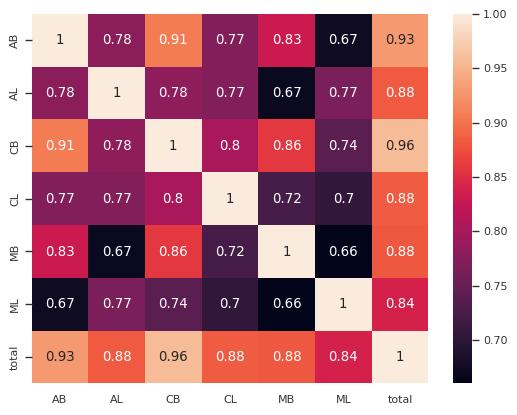

time: 1.55 s (started: 2022-09-21 16:31:14 -03:00)


In [38]:
# Analysis for weekly dataframe

df_all_series = pd.DataFrame()
for key in weekly_series.keys():
  df_all_series[key] = weekly_series[key]['df']['kilos_sum']

sns.heatmap(df_all_series.corr(), annot=True)

Notamos que para casi todos las series por grupo tienen una correlación > ~0.83 respecto de la serie total, lo que nos permite ajustar nuestros modelos respecto a la serie total (con todos los productos) y replicarlos para cada grupo posteriormente.

### Exploración de las series

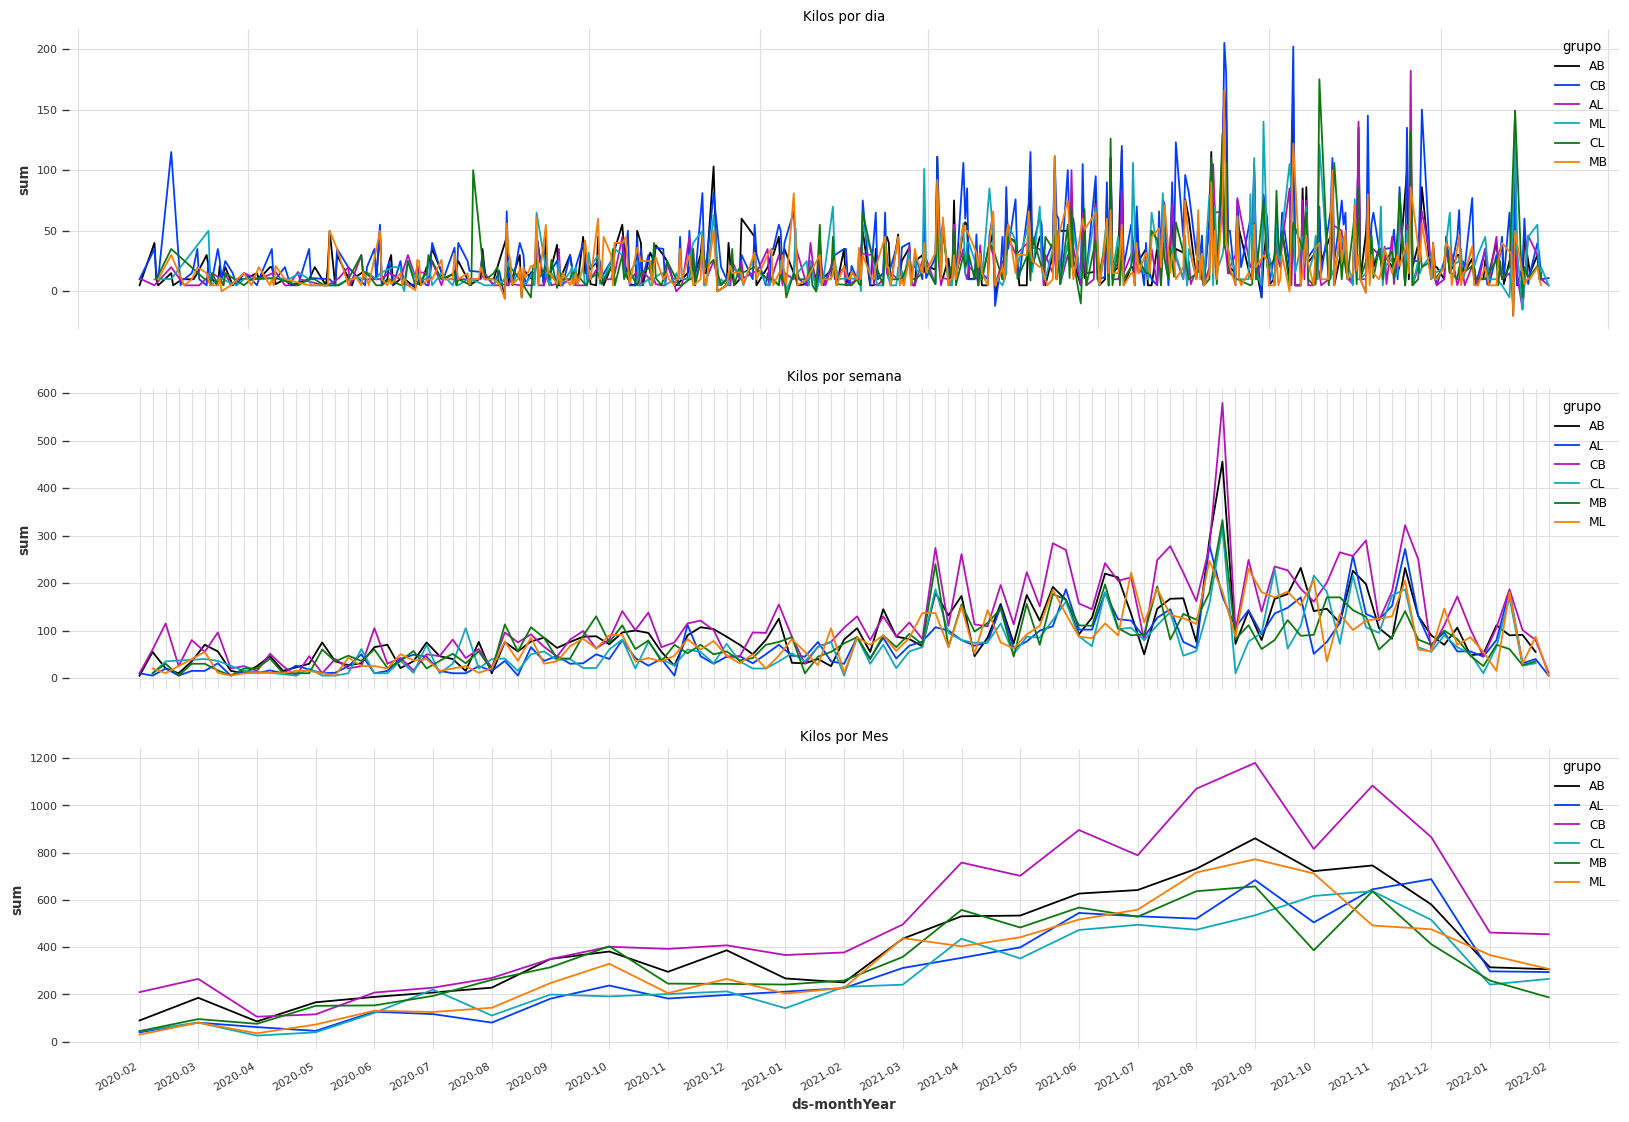

time: 6.16 s (started: 2022-09-21 16:31:18 -03:00)


In [39]:
# Graficaremos la venta total de kilos para cada granularidad de tiempo
fig, ax = plt.subplots(3, 1,figsize=(20,15))
# Diario
df_grouped_daily = df_clean_outliers.sort_values(by=['ds']).groupby(['ds', 'grupo']).agg({'kilos' : ['sum']})
df_grouped_daily.columns = ['sum']
df_grouped_daily.reset_index(inplace = True)
# Semanal
df_grouped_weekly = df_clean_outliers.sort_values(by=['ds']).groupby(['ds-weekYear', 'grupo']).agg({'kilos' : ['sum']})
df_grouped_weekly.columns = ['sum']
df_grouped_weekly.reset_index(inplace = True)
# Mensual
df_grouped_monthly = df_clean_outliers.sort_values(by=['ds']).groupby(['ds-monthYear', 'grupo']).agg({'kilos' : ['sum']})
df_grouped_monthly.columns = ['sum']
df_grouped_monthly.reset_index(inplace = True)
# Graficamos
sns.lineplot(data=df_grouped_daily, x='ds', y='sum', hue='grupo', ax=ax[0])
sns.lineplot(data=df_grouped_weekly, x='ds-weekYear', y='sum', hue='grupo', ax=ax[1])
sns.lineplot(data=df_grouped_monthly, x='ds-monthYear', y='sum', hue='grupo', ax=ax[2])
ax[0].set_title('Kilos por dia')
ax[1].set_title('Kilos por semana')
ax[2].set_title('Kilos por Mes')
fig.autofmt_xdate()

Vemos que la agrupación Diaria es la que presenta mayor variabilidad, por lo que la descartaremos en los siguientes análisis.
Vemos también que la granularidad Mensual es mas estable en su variabilidad, pero presenta menos datos debido a la agrupación, lo que hace mas difícil el entrenamiento de modelos. Mientras, la granularidad semanal se presenta como un buen punto medio para mantener tanto variabilidad como cantidad de puntos, sin embargo igual presenta una volatilidad importante al final de la serie, asi como puntos con valores '0' para ciertos grupos.

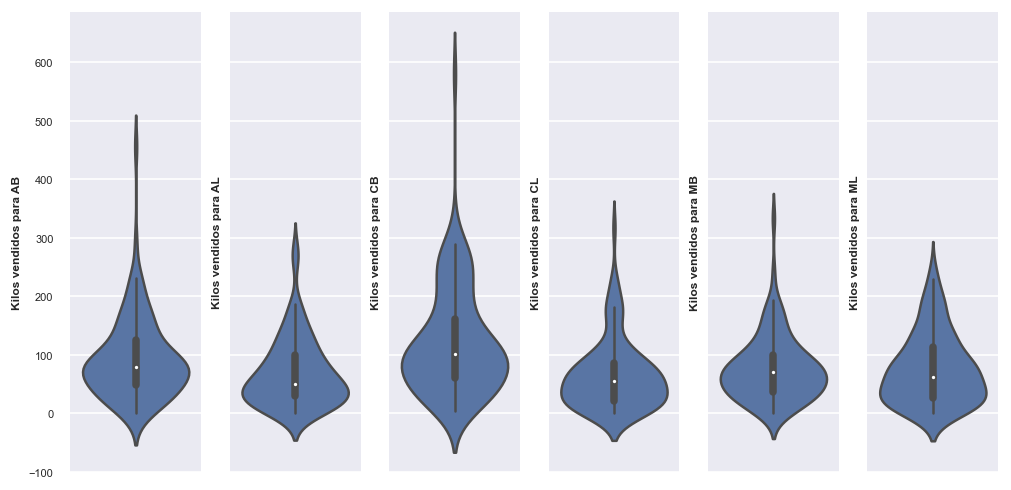

time: 2.44 s (started: 2022-09-21 16:32:49 -03:00)


In [40]:
# Graficamos la distibución de cantidad de kilos por venta
sns.set(font_scale = 0.6)
plt.rcParams["figure.dpi"] = 120
fig, ax = plt.subplots(1, 6, figsize=(10, 5), sharey=True)
for n, i in enumerate(weekly_series.keys()):
    if i == 'total':
        continue
    axis = ax[n]
    df = weekly_series[i]['df']
    sns.violinplot(data = df, y = df['kilos_sum'], ax=axis)
    axis.set_ylabel(f'Kilos vendidos para {i}')

Respecto a la dsitribución de los datos:

- Los productos AB y CB tienen mayor dispersión de venta.
- Los productos M de ambos tipos son los que tienen, en conjunto, una mayor concentración en valores bajos.
- La distribución de venta del producto CB tiene transacciones con mayor cantidad de kilos con respecto a los otros productos (La mediana es mayor al resto asi como el punto donde comienza el tercer cuartil).
- Se observa que los productos con cobertura L, son los que presentan menor dispersión.

In [41]:
from scipy.stats import skew, kurtosis

for n, i in enumerate(weekly_series.keys()):
    df = weekly_series[i]['df']
    print(f'Conjunto de datos {i}, coeficiente de asimetría: ', round(skew(df['kilos_sum']), 2), '| Curtosis: ', round(kurtosis(df['kilos_sum']), 2))

Conjunto de datos AB, coeficiente de asimetría:  1.84 | Curtosis:  6.16
Conjunto de datos AL, coeficiente de asimetría:  1.38 | Curtosis:  2.1
Conjunto de datos CB, coeficiente de asimetría:  1.57 | Curtosis:  4.4
Conjunto de datos CL, coeficiente de asimetría:  1.54 | Curtosis:  2.81
Conjunto de datos MB, coeficiente de asimetría:  1.45 | Curtosis:  3.6
Conjunto de datos ML, coeficiente de asimetría:  0.84 | Curtosis:  -0.02
Conjunto de datos total, coeficiente de asimetría:  1.26 | Curtosis:  2.28
time: 16 ms (started: 2022-09-21 16:32:55 -03:00)


Respecto al coeficiente de asimetría y curtosis (Fischer) para los conjuntos semanales, se tiene:
- Todos los coeficientes de asimetría son mayores a 0: todas las distribuciones tienen concentración de valores mayores a la media, que es empujada con ciertos valores de anulaciones y ventas bajas. La asimetría de la curva total es cercana a 1.3, recogiendo la variabilidad de todos los productos.
- En relación a la curtosis, casi todos los índices son mayores a 0; estas curvas son leptocúrticas, con una gran concentración de valores en las cercanías a la media de cada producto. Existen diferencias importantes entre productos: en el caso del producto ML presenta la curtosis más cercana a 0, más parecida a una distribución normal, y se destaca el producto AB ya que presenta una curtosis muy alta.


### Pruebas ARIMA, granularidad semanal

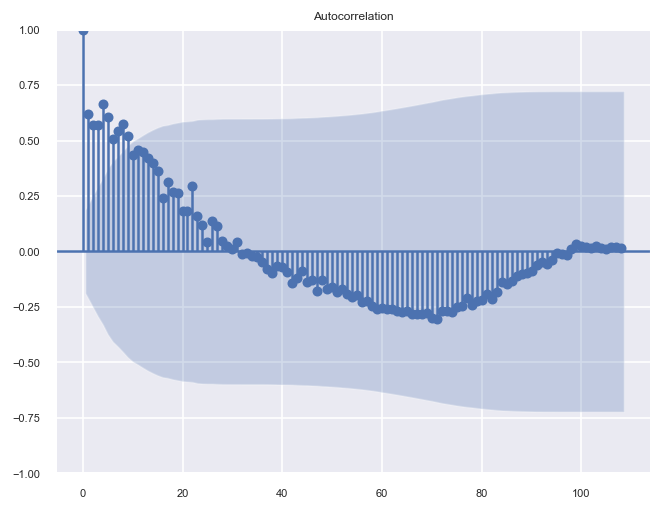

time: 625 ms (started: 2022-09-21 16:32:58 -03:00)


In [42]:
plot_acf(weekly_series['total']['df']['kilos_sum'], lags = 108);

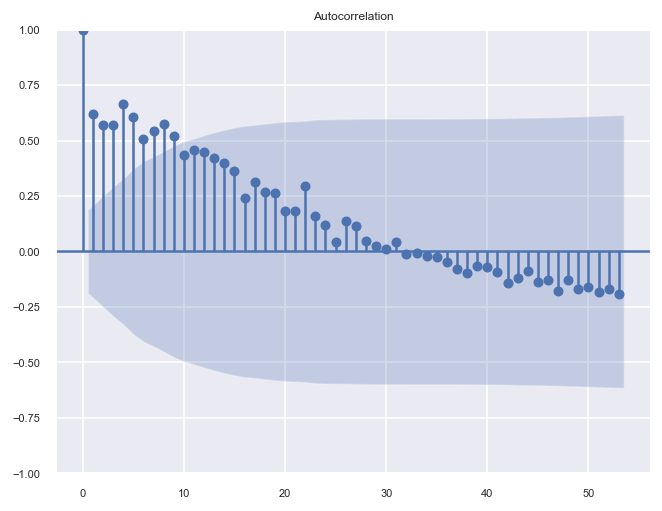

time: 656 ms (started: 2022-09-21 16:33:01 -03:00)


In [43]:
plot_acf(weekly_series['total']['df']['kilos_sum'], lags = 53);

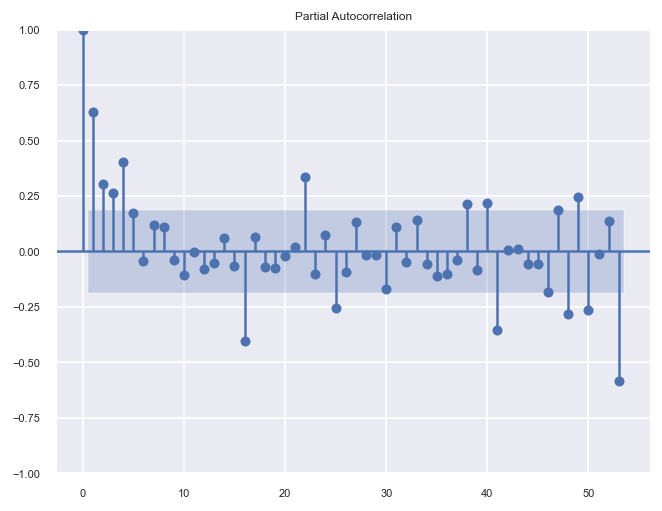

time: 765 ms (started: 2022-09-21 16:33:04 -03:00)


In [44]:
plot_pacf(weekly_series['total']['df']['kilos_sum'], lags = 53);

1. ACF con decrecimiento sinusoidal.
2. PACF muestra algunos lags significativos: 1, 4, 16, 22, 41 y 53.

Lag de 22 semanas, análisis

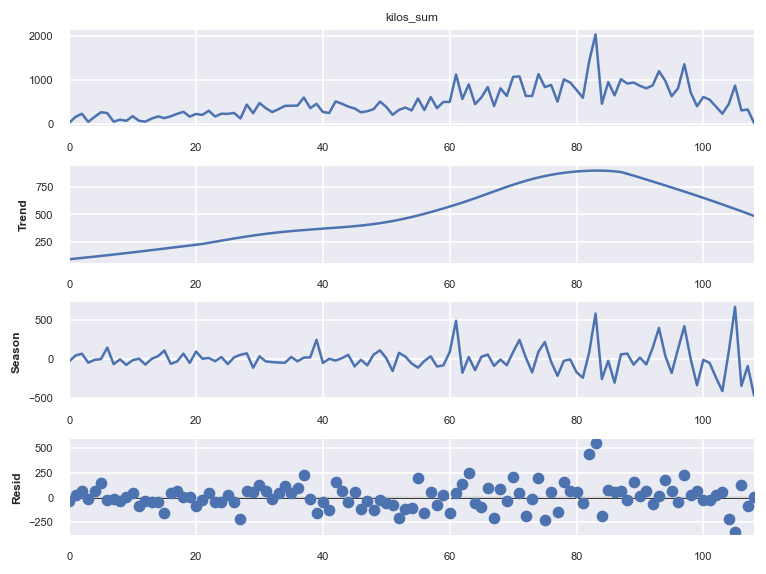

time: 2.62 s (started: 2022-09-21 16:33:07 -03:00)


In [45]:
#se crea un diccionario para hacer un seasonal decompose con STL de todos los lags posibles para la agrupación semanal
#SIN USO
from statsmodels.tsa.seasonal import STL

weekly_seasonaldec1 = STL(weekly_series['total']['df']['kilos_sum'], period = 22).fit()
weekly_seasonaldec1.plot()
sns.despine();

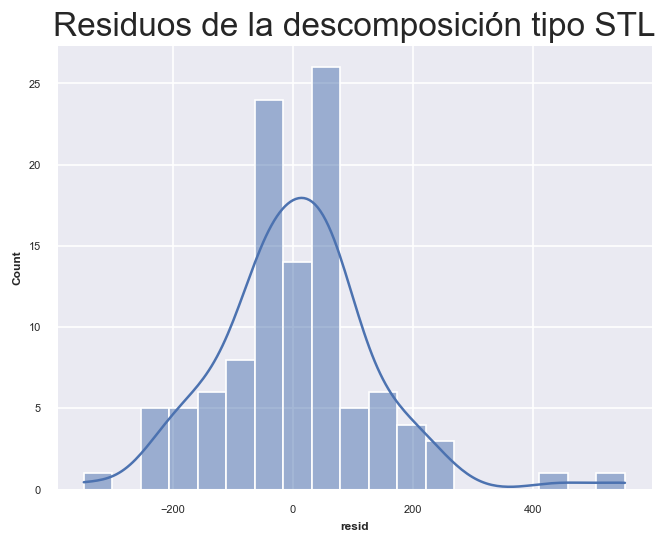

time: 672 ms (started: 2022-09-21 16:33:13 -03:00)


In [46]:
sns.histplot(weekly_seasonaldec1.resid, kde = True)
plt.title('Residuos de la descomposición tipo STL', size = 20)
sns.despine();

1. Se aplicará el test ADF para saber si la serie es estacionaria.
2. Se aplicará Jarque-Bera a los residuos para saber qué comportamiento tienen

In [47]:
from statsmodels.tsa.stattools import adfuller

weekly_seasonaldec1_adf = adfuller(weekly_series['total']['df']['kilos_sum'], autolag = 'AIC')
print('p-value Augmented Dicky-Fuller Test: ', weekly_seasonaldec1_adf[1])

p-value Augmented Dicky-Fuller Test:  0.5457048365877513
time: 79 ms (started: 2022-09-21 16:33:16 -03:00)


No existen antecedentes suficientes, con un intervalo de un 95% de confianza, para rechazar la hipótesis nula: la distribución de la serie en este estado NO es estacionaria. Se eliminará la tendencia para volver a revisar.

In [48]:
from statsmodels.stats.stattools import jarque_bera

weekly_seasonaldec1_jb = jarque_bera(weekly_seasonaldec1.resid)
print('p-value Jarque-Bera test: ', weekly_seasonaldec1_jb[1], '\nSkew: ', weekly_seasonaldec1_jb[2], '\nKurtosis: ', weekly_seasonaldec1_jb[3])

p-value Jarque-Bera test:  2.5446676612844384e-11 
Skew:  0.7431239379926244 
Kurtosis:  5.921227680778331
time: 16 ms (started: 2022-09-21 16:33:20 -03:00)


Nuevamente, con un intervalo de un 95% de confianza, no existen antecedentes suficientes para rechazar la hipótesis nula: la distribución de los residuos no es significativamente distinta de una distribución normal (coeficiente de asimetría o skew > 0, asimetría positiva, cola de los datos se alarga hacia la derecha, por sobre la media; curtosis cercana a 6, muy por sobre 3 de una distribución normal, los datos se agolpan muy cercanos a la media en una distribución leptocúrtica).

A pesar de esto la serie no es estacionaria, por lo que se trabajará ahora con la serie sin tendencia.

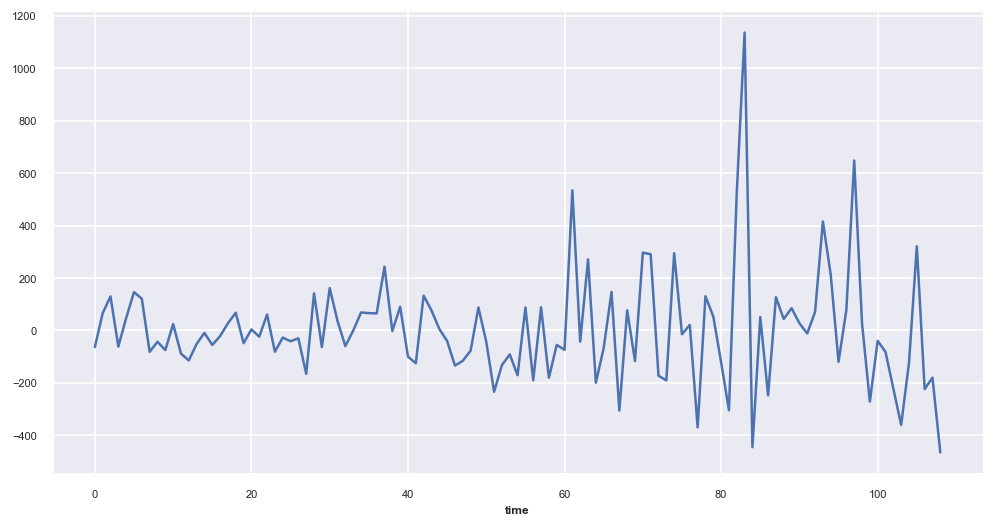

time: 984 ms (started: 2022-09-21 16:33:26 -03:00)


In [49]:
#forma 1: eliminar la componente de tendencia

weekly_seasonaldec1_seasonal1 = weekly_series['total']['df']['kilos_sum'] - weekly_seasonaldec1.trend
plt.figure(figsize=(10,5))
sns.lineplot(data = weekly_seasonaldec1_seasonal1)
sns.despine();

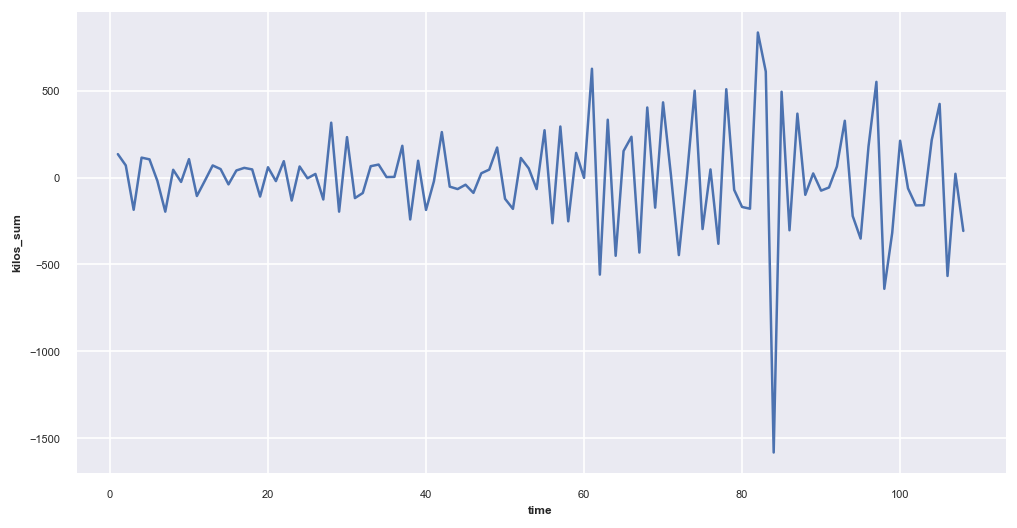

time: 719 ms (started: 2022-09-21 16:33:30 -03:00)


In [50]:
#forma 2: hacer diferenciación

weekly_seasonaldec1_seasonal2 = weekly_series['total']['df']['kilos_sum'].diff()[1:]
plt.figure(figsize=(10,5))
sns.lineplot(data = weekly_seasonaldec1_seasonal2)
sns.despine();

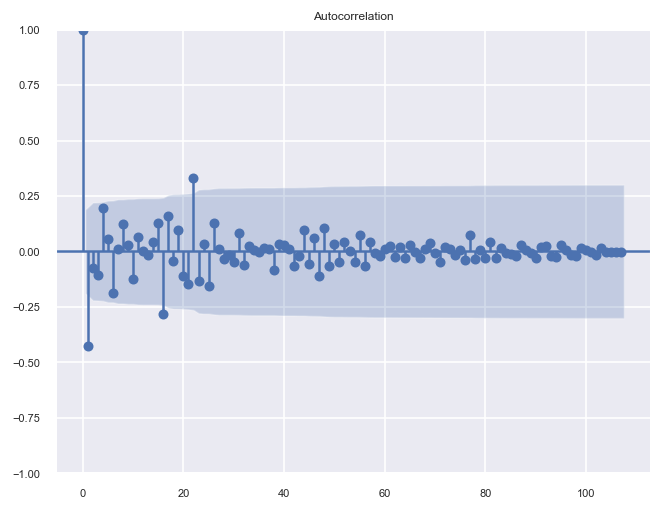

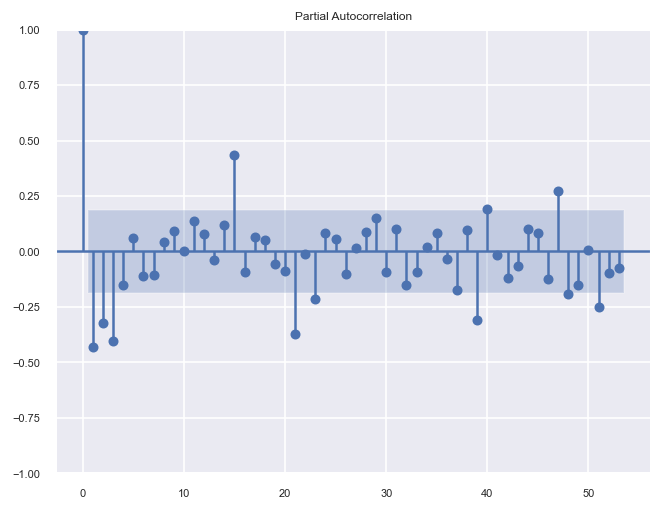

time: 2.33 s (started: 2022-09-21 16:33:33 -03:00)


In [51]:
plot_acf(weekly_seasonaldec1_seasonal2, lags = 107);
plot_pacf(weekly_seasonaldec1_seasonal2, lags = 53);

In [52]:
weekly_seasonaldec1_seasonal_adf1 = adfuller(weekly_seasonaldec1_seasonal1, autolag = 'AIC')
print('p-value Augmented Dicky-Fuller Test: ', weekly_seasonaldec1_seasonal_adf1[1])

weekly_seasonaldec1_seasonal_adf2 = adfuller(weekly_seasonaldec1_seasonal2, autolag = 'AIC')
print('p-value Augmented Dicky-Fuller Test: ', weekly_seasonaldec1_seasonal_adf2[1])

p-value Augmented Dicky-Fuller Test:  0.00018110423060464572
p-value Augmented Dicky-Fuller Test:  6.2187873758505166e-15
time: 94 ms (started: 2022-09-21 16:33:38 -03:00)


Ahora, con un intervalo de un 95% de confianza, no se puede rechazar la hipótesis nula ya que el p-value es mayor al valor de corte: esta distribución sí es estacionaria eliminando la tendencia, o con una diferenciación de d=1. Se tomará la segunda alternativa para incorporarla como parámetro al modelo ARIMA.

### Incorporación de variables exógenas (análisis semanal y mensual)

Se incorporarán los datos de:

1. Contagios diarios de COVID-19 en Chile
2. Temperatura media diaria
3. IPC total

Se revisará el comportamiento de las variables, y se comparará la variación porcentual de las ventas, con la de cada variable, a través del índice de correlación (método .corr()).

In [53]:
df_covid = pd.read_csv('covid.csv')
df_covid.drop(columns = ['categoria'], inplace = True)

df_ipc = pd.read_csv('IPC.csv')
df_ipc.drop(columns = ['IPC específico (%)'], inplace = True)
df_ipc = refactor({'Fecha' : 'fecha', 'IPC total (%)' : 'ipc'}, df_ipc)

FileNotFoundError: [Errno 2] No such file or directory: 'covid.csv'

time: 640 ms (started: 2022-09-21 16:33:41 -03:00)


In [440]:
df_covid.fecha = pd.to_datetime(df_covid['fecha'], format = '%Y/%m/%d')
df_covid.casos.astype('int64')

df_ipc.fecha = pd.to_datetime(df_ipc['fecha'], format = '%d/%m/%Y')
df_ipc.ipc.astype('float')

0       0.1
1       0.1
2       0.1
3       0.1
4       0.1
       ... 
1150    0.3
1151    0.3
1152    0.3
1153    0.3
1154    0.3
Name: ipc, Length: 1155, dtype: float64

time: 15 ms (started: 2022-03-17 17:10:12 -03:00)


In [441]:
#conversión y limitación de datos según fecha

df_covid2 = df_covid.loc[(df_covid['fecha'] >= pd.to_datetime('2020-02-01')) & (df_covid['fecha'] <= pd.to_datetime('2022-02-28'))]
df_ipc2 = df_ipc[df_ipc['fecha'] >= pd.to_datetime('2020-02-01')]
df_temperature_week = df_temperature_week[df_temperature_week.index >= pd.to_datetime('2020-02-01')]
df_temperature_month = df_temperature_month[df_temperature_month.index >= pd.to_datetime('2020-02-01')]

df_covid_week = pd.DataFrame(df_covid2.groupby([pd.Grouper(key = 'fecha', freq = 'W-MON', label = 'left')])['casos'].mean())
df_ipc_week = pd.DataFrame(df_ipc2.groupby([pd.Grouper(key = 'fecha', freq = 'W-MON', label = 'left')])['ipc'].mean())

df_covid_week.reset_index(inplace = True)
df_ipc_week.reset_index(inplace = True)

df_covid_month = pd.DataFrame(df_covid2.groupby([pd.Grouper(key = 'fecha', freq = 'M', label = 'left')])['casos'].mean())
df_ipc_month = pd.DataFrame(df_ipc2.groupby([pd.Grouper(key = 'fecha', freq = 'M', label = 'left')])['ipc'].mean())

#df_covid_week.reset_index(inplace = True)
#df_ipc_week.reset_index(inplace = True)

#df_covid_month.reset_index(inplace = True)
#df_ipc_month.reset_index(inplace = True)


time: 47 ms (started: 2022-03-17 17:10:15 -03:00)


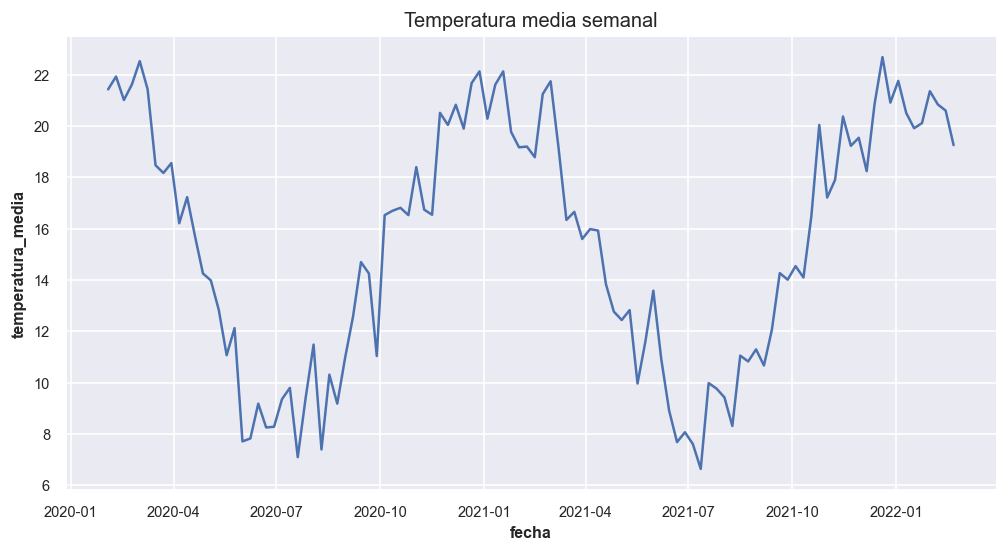

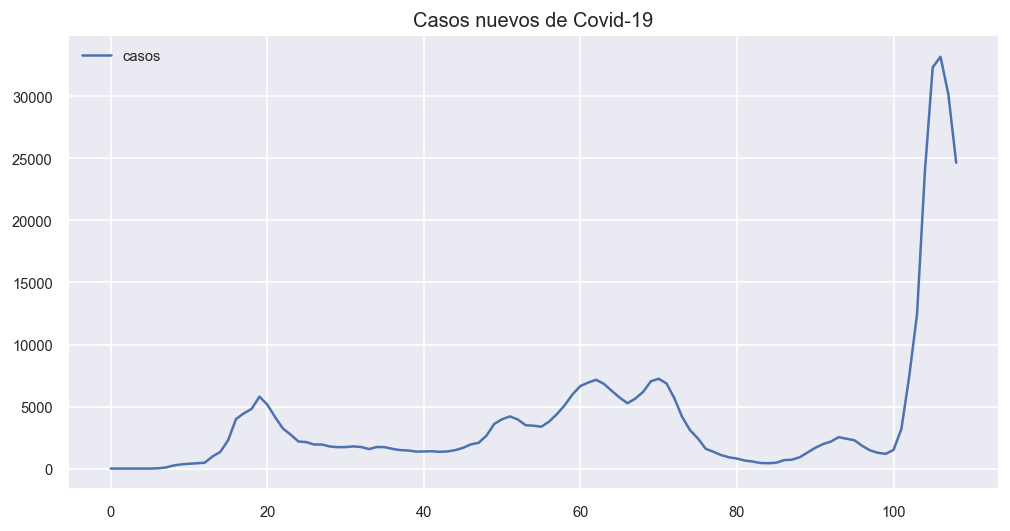

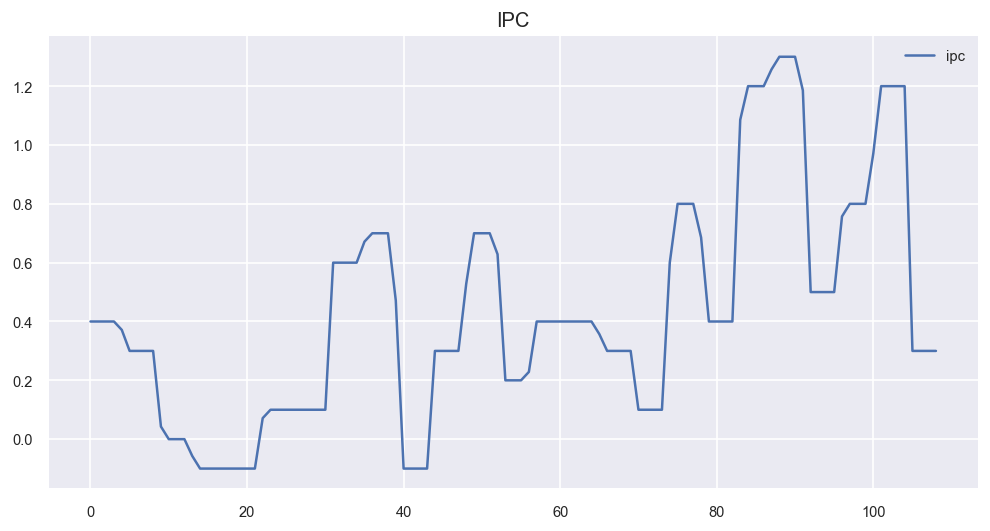

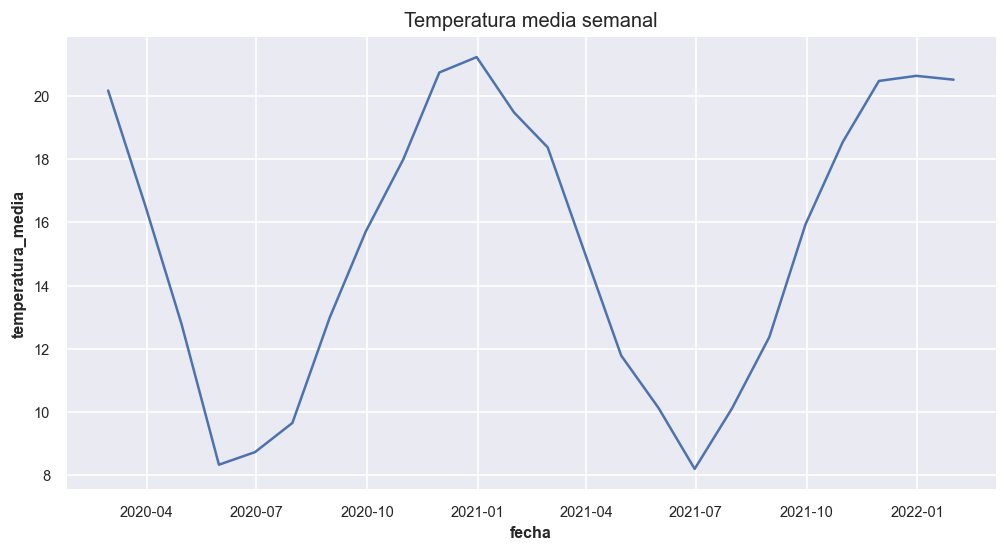

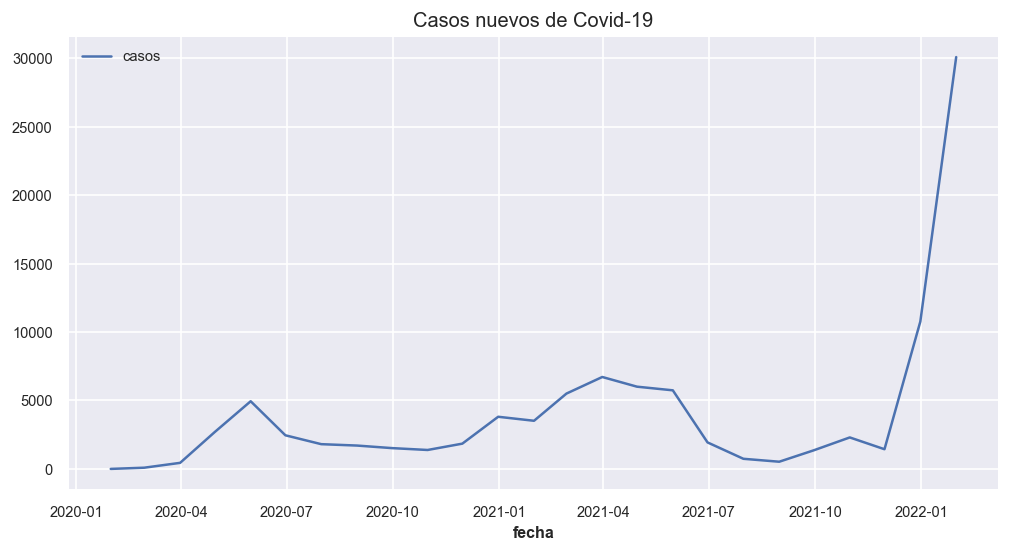

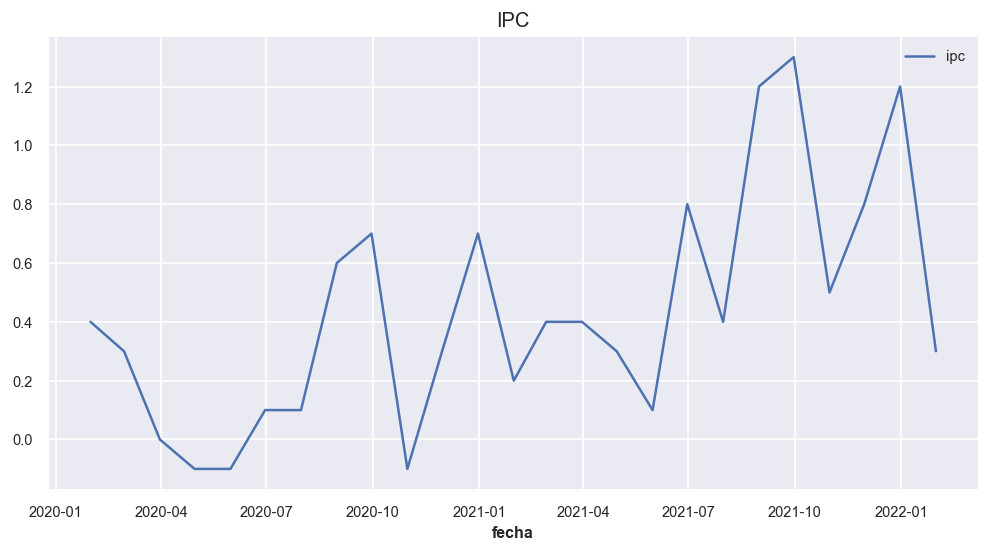

time: 4.36 s (started: 2022-03-17 17:10:41 -03:00)


In [443]:
#gráficos semanales
plt.figure(figsize=(10,5))
plt.title('Temperatura media semanal', size = 12)
sns.lineplot(data = df_temperature_week['temperatura_media'])
sns.despine();

plt.figure(figsize=(10,5))
plt.title('Casos nuevos de Covid-19', size = 12)
sns.lineplot(data = df_covid_week)
sns.despine();

plt.figure(figsize=(10,5))
plt.title('IPC', size = 12)
sns.lineplot(data = df_ipc_week)
sns.despine();

#gráficos mensuales
plt.figure(figsize=(10,5))
plt.title('Temperatura media semanal', size = 12)
sns.lineplot(data = df_temperature_month['temperatura_media'])
sns.despine();

plt.figure(figsize=(10,5))
plt.title('Casos nuevos de Covid-19', size = 12)
sns.lineplot(data = df_covid_month)
sns.despine();

plt.figure(figsize=(10,5))
plt.title('IPC', size = 12)
sns.lineplot(data = df_ipc_month)
sns.despine();

In [444]:
#cambios porcentuales semanales y mensuales

df_temperature_week['pct'] = df_temperature_week['temperatura_media'].pct_change()
df_covid_week['pct'] = df_covid_week['casos'].pct_change()
df_ipc_week['pct'] = df_ipc_week['ipc'].pct_change()
sales_week_pct = weekly_series['total']['df']['kilos_sum'].pct_change()

df_temperature_month['pct'] = df_temperature_month['temperatura_media'].pct_change()
df_covid_month['pct'] = df_covid_month['casos'].pct_change()
df_ipc_month['pct'] = df_ipc_month['ipc'].pct_change()
sales_month_pct = monthly_series['total']['df']['kilos_sum'].pct_change()

time: 31 ms (started: 2022-03-17 17:10:50 -03:00)


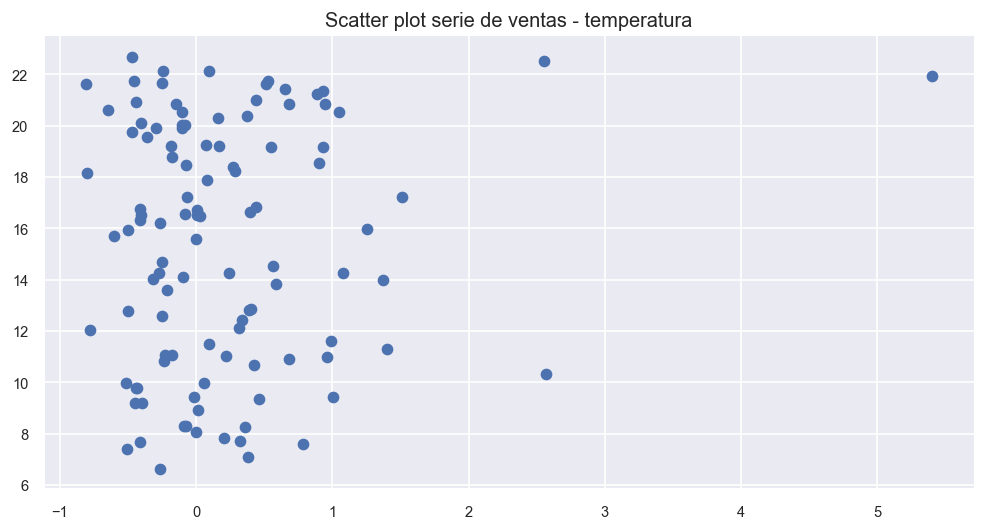

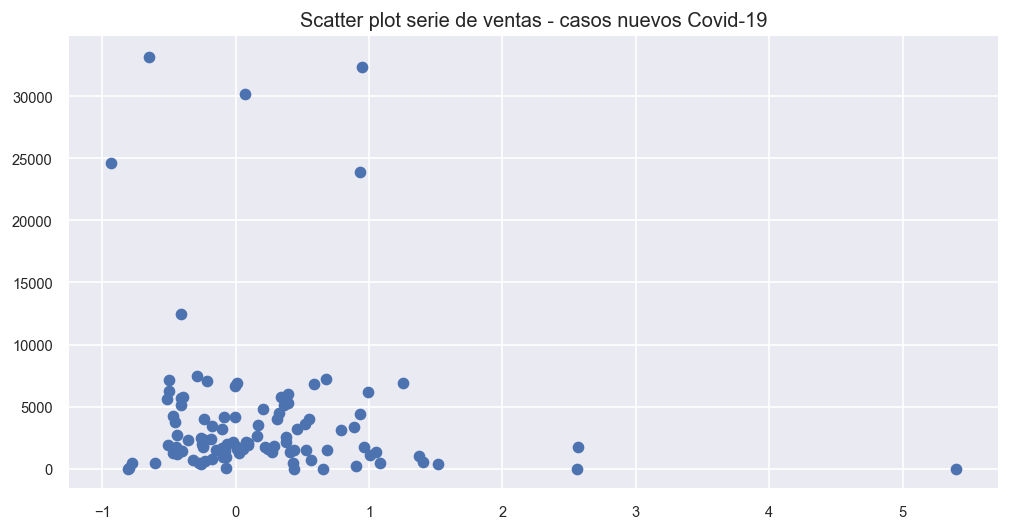

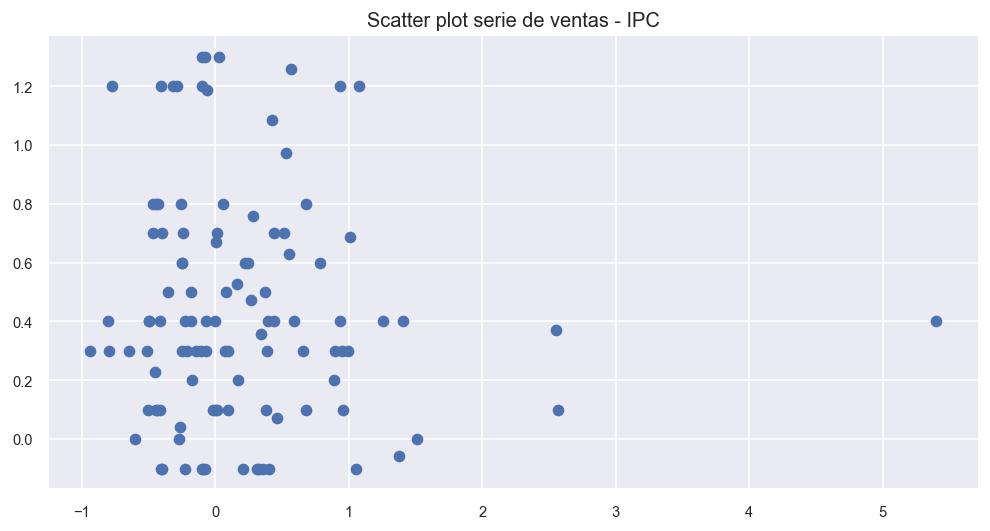

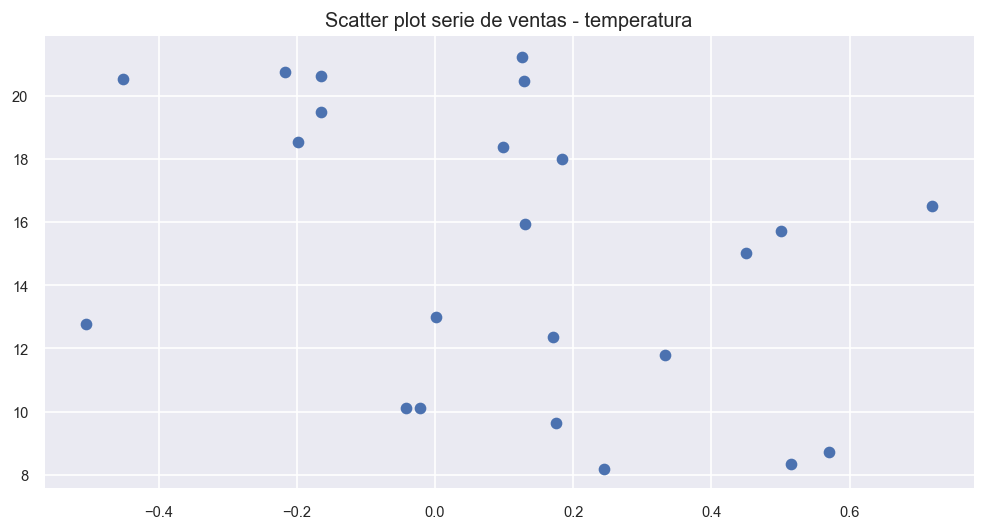

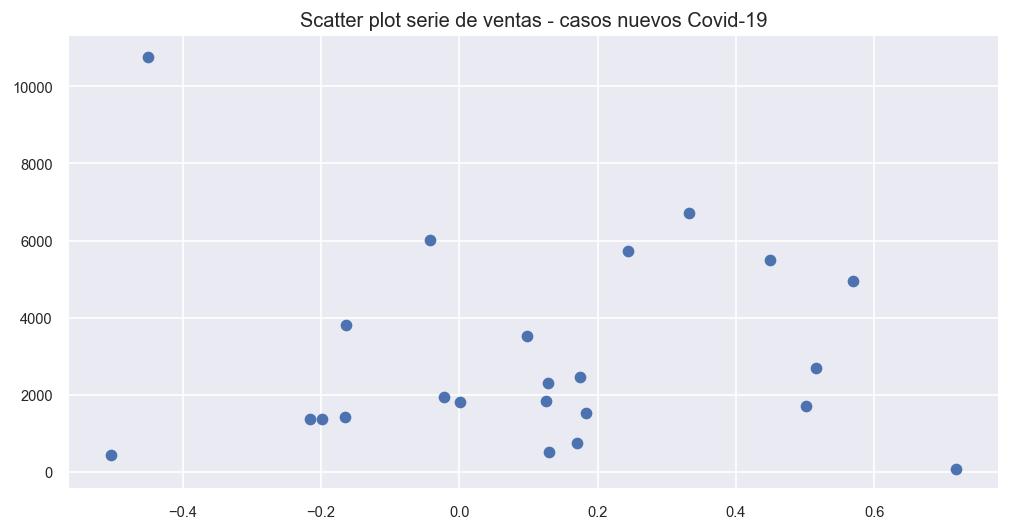

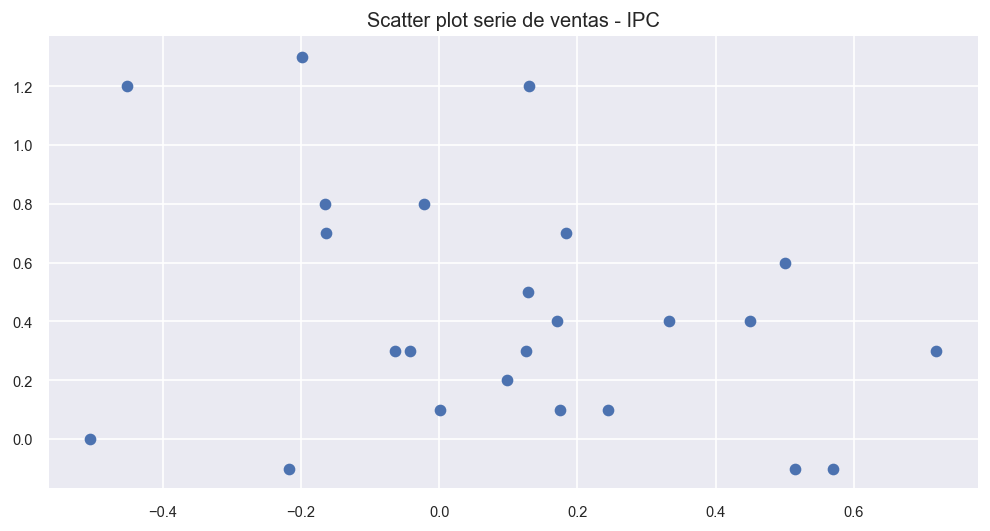

time: 3.89 s (started: 2022-03-17 17:12:21 -03:00)


In [449]:
sales1 = sales_week_pct
sales2 = sales_week_pct[:-1]
temperature = df_temperature_week['temperatura_media']
covid = df_covid_week['casos']
ipc = df_ipc_week['ipc']

sales3 = sales_month_pct
sales4 = sales_month_pct[:-1]
temperature2 = df_temperature_month['temperatura_media']
covid2 = df_covid_month['casos']
ipc2 = df_ipc_month['ipc']

#análisis semanal
plt.figure(figsize=(10,5))
plt.title('Scatter plot serie de ventas - temperatura', size = 12)
plt.scatter(sales2, df_temperature_week['temperatura_media'])
sns.despine();

plt.figure(figsize=(10,5))
plt.title('Scatter plot serie de ventas - casos nuevos Covid-19', size = 12)
plt.scatter(sales1, df_covid_week['casos'])
sns.despine();

plt.figure(figsize=(10,5))
plt.title('Scatter plot serie de ventas - IPC', size = 12)
plt.scatter(sales1, df_ipc_week['ipc'])
sns.despine();

#análisis mensual
plt.figure(figsize=(10,5))
plt.title('Scatter plot serie de ventas - temperatura', size = 12)
plt.scatter(sales4, df_temperature_month['temperatura_media'])
sns.despine();

plt.figure(figsize=(10,5))
plt.title('Scatter plot serie de ventas - casos nuevos Covid-19', size = 12)
plt.scatter(sales4, df_covid_month['casos'][:-1])
sns.despine();

plt.figure(figsize=(10,5))
plt.title('Scatter plot serie de ventas - IPC', size = 12)
plt.scatter(sales3, df_ipc_month['ipc'])
sns.despine();

In [451]:
print('Análisis semanal', '\nÍndice de correlación entre ventas y temperatura: ', sales2.corr(temperature), '\nÍndice de correlación entre ventas y Covid-19: ', sales1.corr(covid), '\nÍndice de correlación entre ventas e IPC: ', sales1.corr(ipc))

Análisis semanal 
Índice de correlación entre ventas y temperatura:  nan 
Índice de correlación entre ventas y Covid-19:  -0.08469791714954338 
Índice de correlación entre ventas e IPC:  -0.06372813057421392
time: 0 ns (started: 2022-03-17 17:12:43 -03:00)


In [452]:
print('Análisis mensual', '\nÍndice de correlación entre ventas y temperatura: ', sales4.corr(temperature2), '\nÍndice de correlación entre ventas y Covid-19: ', sales4.corr(covid2), '\nÍndice de correlación entre ventas e IPC: ', sales3.corr(ipc2))

Análisis mensual 
Índice de correlación entre ventas y temperatura:  nan 
Índice de correlación entre ventas y Covid-19:  nan 
Índice de correlación entre ventas e IPC:  nan
time: 16 ms (started: 2022-03-17 17:13:18 -03:00)


In [463]:
print(np.unique(sales1 == np.NaN), np.unique(sales2 == np.NaN), np.unique(temperature == np.NaN), np.unique(covid == np.NaN), np.unique(ipc == np.NaN), np.unique(sales3 == np.NaN), np.unique(sales4 == np.NaN), np.unique(temperature2 == np.NaN), np.unique(covid2 == np.NaN), np.unique(ipc2 == np.NaN))

[False] [False] [False] [False] [False] [False] [False] [False] [False] [False]
time: 0 ns (started: 2022-03-17 17:17:32 -03:00)


Los índices de correlación calculados son nulos (se corrobora que no existan datos nulos que pudieran estar generando este resultado): estos no muestran que las variables exógenas propuestas pudieran ayudar a los modelos a tener un mejor rendimiento, por lo que no serán incorporadas en el análisis semanal.

### Análisis AR

Sobre conjunto test

In [54]:
p_param = 22
d_param = 1 
q_param = 0

time: 31 ms (started: 2022-09-21 19:55:22 -03:00)


In [55]:
from statsmodels.tsa.arima.model import ARIMA

train_0, test_0 = weekly_series['total']['df']['kilos_sum'][:-24], weekly_series['total']['df']['kilos_sum'][-24:]
len_test = len(test_0)

arima_pred = []

for i in range(len_test):
    train = weekly_series['total']['df']['kilos_sum'][:-(len_test - i)]
    arima = ARIMA(train, order = (p_param, d_param, q_param))
    arima_fit = arima.fit(low_memory = True)
    arima_preds = arima_fit.forecast(steps = 1)

    arima_pred.append(arima_preds.values[0])
    
df_results1 = pd.DataFrame(columns = ['pred_no', 'pred'])
df_results1['pred_no'] = list(test_0.index)
df_results1['pred'] = arima_pred
df_results1.set_index('pred_no')

c:\Users\fnpin\.conda\envs\fnpg1\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\fnpin\.conda\envs\fnpg1\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\fnpin\.conda\envs\fnpg1\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\fnpin\.conda\envs\fnpg1\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\fnpin\.conda\envs\fnpg1\lib\site-packages\statsmodels\base\

,pred
pred_no,
85,948.812860
86,792.971889
87,1571.620682
88,912.248510
89,423.385623
90,1284.250652
91,1499.323529
92,830.828982
93,778.026251


time: 1min 59s (started: 2022-09-21 19:55:24 -03:00)


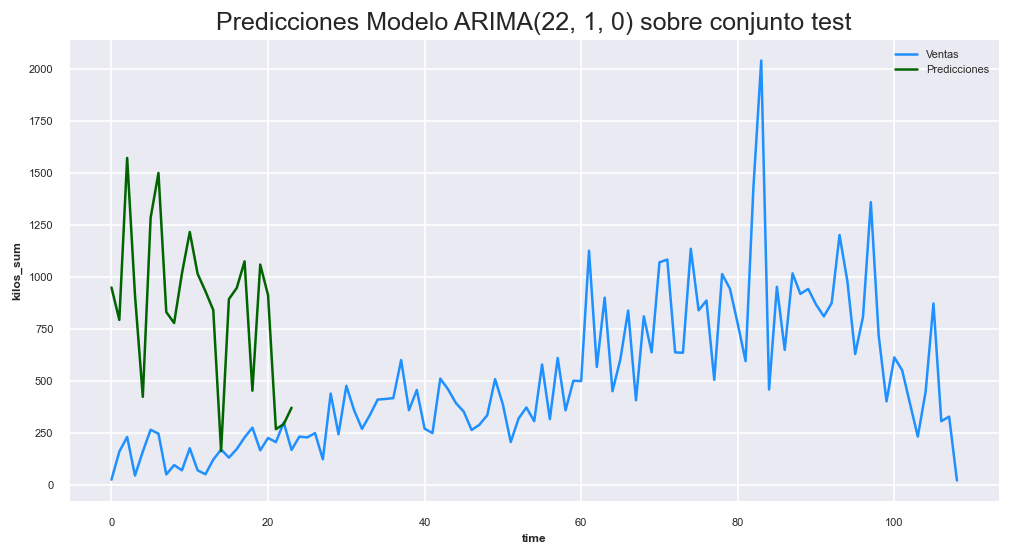

time: 1.72 s (started: 2022-09-21 20:21:16 -03:00)


In [56]:
plt.figure(figsize=(10,5))

plt.title('Predicciones Modelo ARIMA(22, 1, 0) sobre conjunto test', size = 15)

sns.lineplot(data = weekly_series['total']['df']['kilos_sum'], label = 'Ventas', color = 'dodgerblue')
sns.lineplot(data = df_results1['pred'], color = 'darkgreen', label = 'Predicciones')
sns.despine();

#desplazar

In [57]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error

mean_absolute_percentage_error(test_0, arima_pred) #y_true, y_pred

1.1476444869117597

time: 31 ms (started: 2022-09-21 20:21:21 -03:00)


El MAPE es extremadamente alto y la curva no se ajusta a las ventas reales. Se continuará revisando los residuos, y posteriormente se evaluará el conjunto train, que tiene mayor cantidad de meses (febrero 2020 a agosto 2021).

In [58]:
residuals_arima = test_0 - arima_pred
residuals_arima

time
85       3.387140
86    -143.971889
87    -554.620682
88       5.751490
89     518.614377
90    -417.250652
91    -689.323529
92      43.171018
93     422.973749
94     -36.547776
95    -586.579336
96    -206.918989
97     428.013116
98    -121.375342
99     238.709970
100   -280.023905
101   -395.555863
102   -683.490972
103   -220.553664
104   -610.987524
105    -40.109771
106     38.346346
107     36.121965
108   -349.826499
Name: kilos_sum, dtype: float64

time: 16 ms (started: 2022-09-21 20:21:25 -03:00)


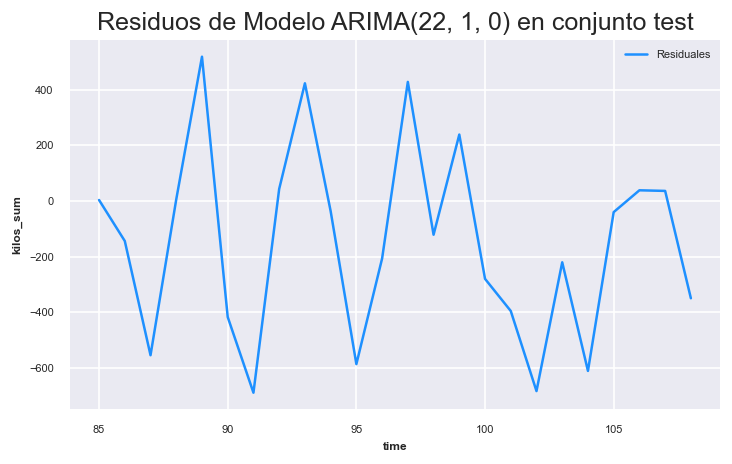

time: 718 ms (started: 2022-09-21 20:21:28 -03:00)


In [59]:
plt.figure(figsize=(7,4))

plt.title('Residuos de Modelo ARIMA(22, 1, 0) en conjunto test', size = 15)

sns.lineplot(data = residuals_arima, label = 'Residuales', color = 'dodgerblue')
sns.despine();

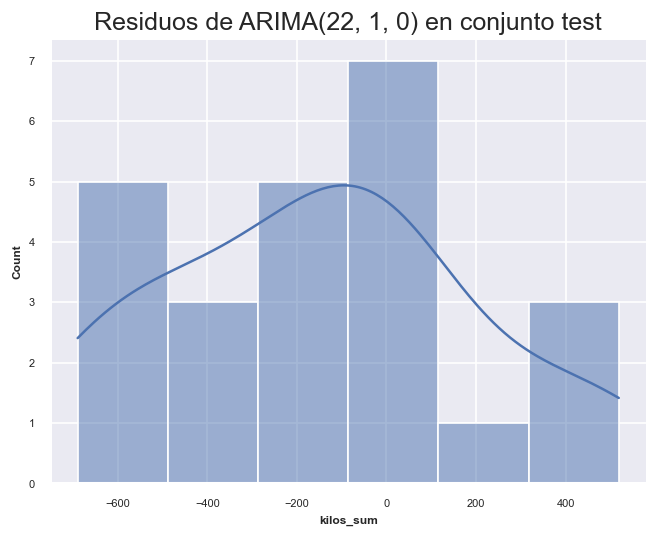

time: 1.06 s (started: 2022-09-21 20:21:31 -03:00)


In [60]:
sns.histplot(residuals_arima, kde = True)
plt.title('Residuos de ARIMA(22, 1, 0) en conjunto test', size = 15)
sns.despine();

In [61]:
from statsmodels.stats.stattools import jarque_bera

weekly_arimaresid_jb = jarque_bera(residuals_arima)
print('p-value Jarque-Bera test: ', weekly_arimaresid_jb[1], '\nSkew: ', weekly_arimaresid_jb[2], '\nKurtosis: ', weekly_arimaresid_jb[3])

p-value Jarque-Bera test:  0.7196838165481225 
Skew:  0.178937555422195 
Kurtosis:  2.272118128229473
time: 15 ms (started: 2022-09-21 20:21:36 -03:00)


El p-value del test arroja, con un intervalo de un 95% de confianza, que los residuos sí tienen una distribución normal. Se continuará revisando el conjunto train.

Aplicación de modelo sobre conjunto train

In [62]:
len_train = len(train_0)

arima_pred = []

for i in range(23, len_train):
    train = weekly_series['total']['df']['kilos_sum'][:-(len_train - i)]
    arima = ARIMA(train, order = (p_param, d_param, q_param))
    arima_fit = arima.fit(low_memory = True)
    arima_preds = arima_fit.forecast(steps = 1)
    arima_pred.append(arima_preds.values[0])

df_results1 = pd.DataFrame(columns = ['pred_no', 'pred'])
df_results1['pred_no'] = list(train_0.index[23:])
df_results1['pred'] = arima_pred
df_results1.set_index('pred_no')


c:\Users\fnpin\.conda\envs\fnpg1\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\fnpin\.conda\envs\fnpg1\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\fnpin\.conda\envs\fnpg1\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\fnpin\.conda\envs\fnpg1\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\fnpin\.conda\envs\fnpg1\lib\site-packages\statsmodels\base\

,pred
pred_no,
23,0.000000
24,313.246204
25,308.008456
26,433.981938
27,606.777602
...,...
80,1058.987524
81,912.109771
82,267.653654


time: 3min 49s (started: 2022-09-21 20:21:38 -03:00)


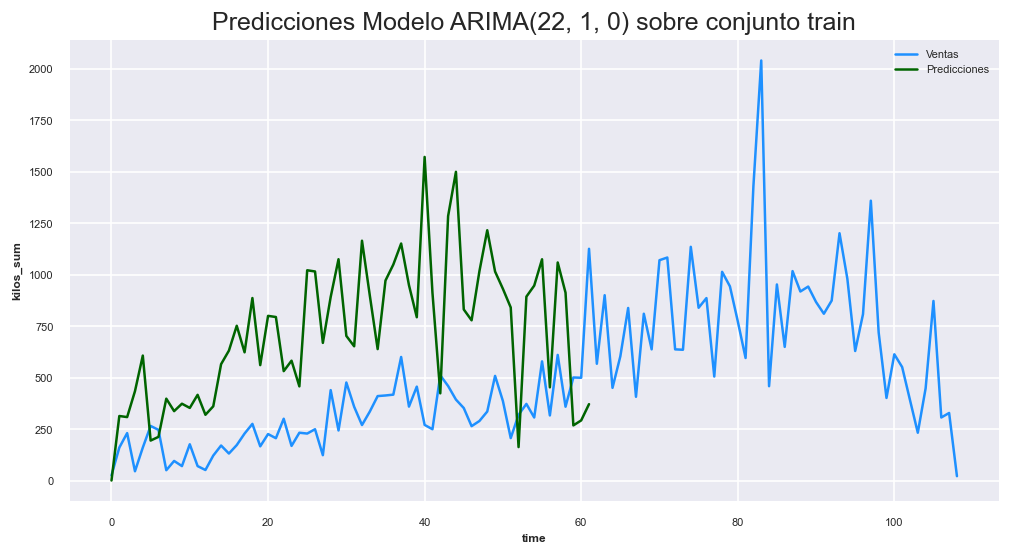

time: 1.83 s (started: 2022-09-21 20:30:32 -03:00)


In [63]:
plt.figure(figsize=(10,5))

plt.title('Predicciones Modelo ARIMA(22, 1, 0) sobre conjunto train', size = 15)

sns.lineplot(data = weekly_series['total']['df']['kilos_sum'], label = 'Ventas', color = 'dodgerblue')
sns.lineplot(data = df_results1['pred'], color = 'darkgreen', label = 'Predicciones')
sns.despine();

In [64]:
mean_absolute_percentage_error(train_0[23:], arima_pred)

0.7856038225029551

time: 16 ms (started: 2022-09-21 20:30:38 -03:00)


El MAPE disminuye en este caso, probablemente causado por la mayor cantidad de información con la cual contrastar. Por otro lado, el MAPE debió ser ajustado a una menor cantidad de semanas por problemas de modelación (ocupando desde la semana 17 en adelante del conjunto, al no hacerlo el modelo no podía ajustarse). Se continúa con el trabajo de residuales.

In [65]:
residuals_arima = train_0[23:] - arima_pred
residuals_arima

time
23     168.000000
24     -81.246204
25     -80.008456
26    -184.981938
27    -483.777602
         ...     
80    -284.987524
81    -317.109771
82    1162.346346
83    1748.121965
84      87.173501
Name: kilos_sum, Length: 62, dtype: float64

time: 31 ms (started: 2022-09-21 20:30:42 -03:00)


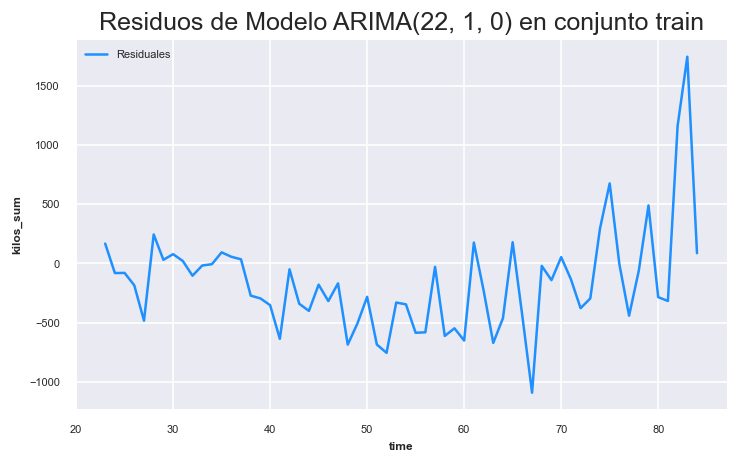

time: 718 ms (started: 2022-09-21 20:30:44 -03:00)


In [66]:
plt.figure(figsize=(7,4))

plt.title('Residuos de Modelo ARIMA(22, 1, 0) en conjunto train', size = 15)

sns.lineplot(data = residuals_arima, label = 'Residuales', color = 'dodgerblue')
sns.despine();

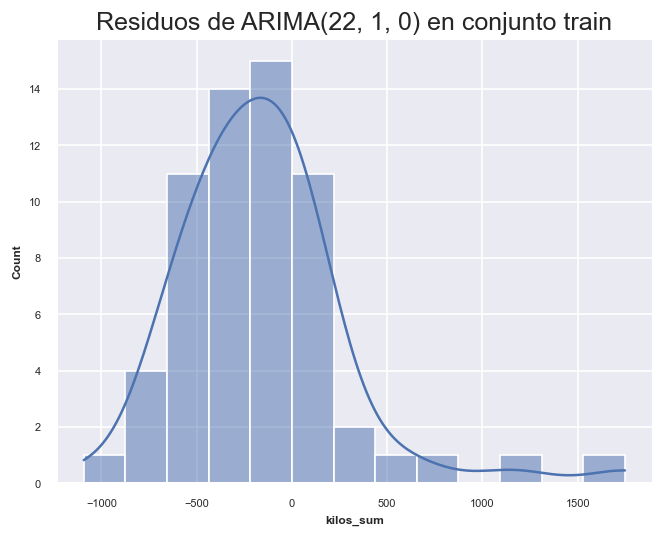

time: 828 ms (started: 2022-09-21 20:30:51 -03:00)


In [67]:
sns.histplot(residuals_arima, kde = True)
plt.title('Residuos de ARIMA(22, 1, 0) en conjunto train', size = 15)
sns.despine();

In [68]:
weekly_arimaresid_jb = jarque_bera(residuals_arima)
print('p-value Jarque-Bera train: ', weekly_arimaresid_jb[1], '\nSkew: ', weekly_arimaresid_jb[2], '\nKurtosis: ', weekly_arimaresid_jb[3])

p-value Jarque-Bera train:  7.405648172272891e-22 
Skew:  1.6120095874332494 
Kurtosis:  8.222432410808928
time: 16 ms (started: 2022-09-21 20:30:54 -03:00)


En este caso, los residuos no tienen una distribución normal. Se continuará revisando la componente de media móvil.

### Análisis MA

Análisis sobre conjunto test

In [69]:
p_param = 22
d_param = 1
q_param = 4

time: 15 ms (started: 2022-09-21 20:30:57 -03:00)


In [70]:
train_0, test_0 = weekly_series['total']['df']['kilos_sum'][:-24], weekly_series['total']['df']['kilos_sum'][-24:]
len_test = len(test_0)

arima_pred = []

for i in range(len_test):
    train = weekly_series['total']['df']['kilos_sum'][:-(len_test - i)]
    arima = ARIMA(train, order = (p_param, d_param, q_param))
    arima_fit = arima.fit()
    arima_preds = arima_fit.forecast(steps = 1)
    arima_pred.append(arima_preds.values[0])

df_results1 = pd.DataFrame(columns = ['pred_no', 'pred'])
df_results1['pred_no'] = list(test_0.index)
df_results1['pred'] = arima_pred
df_results1.set_index('pred_no')

c:\Users\fnpin\.conda\envs\fnpg1\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\fnpin\.conda\envs\fnpg1\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\fnpin\.conda\envs\fnpg1\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\fnpin\.conda\envs\fnpg1\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\fnpin\.conda\envs\fnpg1\lib\site-packages\statsmodels\base\

,pred
pred_no,
85,961.745214
86,816.763394
87,1584.013930
88,1113.399885
89,496.619667
90,1111.774888
91,1540.585711
92,842.420208
93,711.118304


time: 1min 52s (started: 2022-09-21 20:31:00 -03:00)


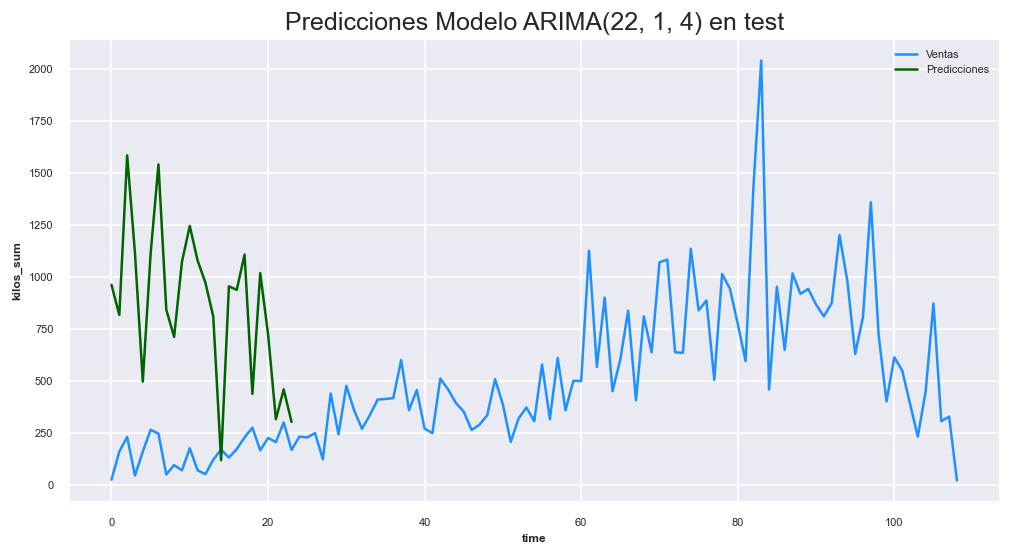

time: 937 ms (started: 2022-09-21 20:36:12 -03:00)


In [71]:
plt.figure(figsize=(10,5))

plt.title('Predicciones Modelo ARIMA(22, 1, 4) en test', size = 15)

sns.lineplot(data = weekly_series['total']['df']['kilos_sum'], label = 'Ventas', color = 'dodgerblue')
sns.lineplot(data = df_results1['pred'], color = 'darkgreen', label = 'Predicciones')
sns.despine();

In [72]:
mean_absolute_percentage_error(test_0, arima_pred)

1.0382520417074474

time: 16 ms (started: 2022-09-21 20:36:17 -03:00)


In [73]:
residuals_arima = test_0 - arima_pred
residuals_arima

time
85      -9.545214
86    -167.763394
87    -567.013930
88    -195.399885
89     445.380333
90    -244.774888
91    -730.585711
92      31.579792
93     489.881696
94     -92.250471
95    -615.733244
96    -270.738999
97     387.400111
98     -90.141954
99     282.379042
100   -341.555280
101   -386.477901
102   -716.355811
103   -205.441407
104   -570.255172
105    147.455988
106     -9.626472
107   -130.800966
108   -281.543313
Name: kilos_sum, dtype: float64

time: 0 ns (started: 2022-09-21 20:36:19 -03:00)


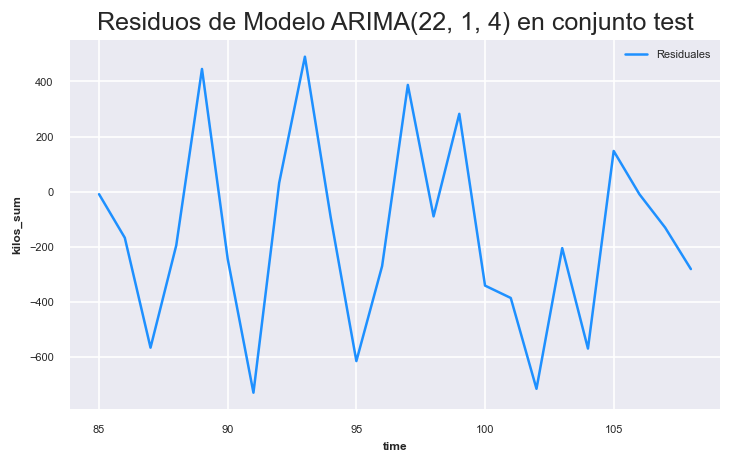

time: 922 ms (started: 2022-09-21 20:36:22 -03:00)


In [74]:
plt.figure(figsize=(7,4))

plt.title('Residuos de Modelo ARIMA(22, 1, 4) en conjunto test', size = 15)

sns.lineplot(data = residuals_arima, label = 'Residuales', color = 'dodgerblue')
sns.despine();

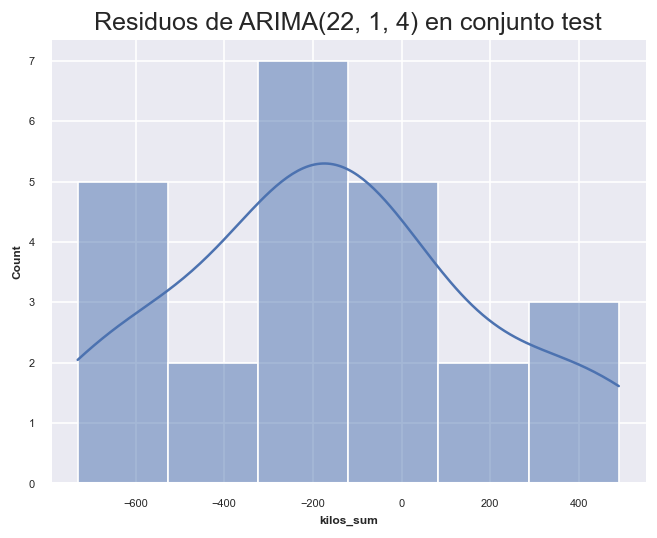

time: 812 ms (started: 2022-09-21 20:36:25 -03:00)


In [75]:
sns.histplot(residuals_arima, kde = True)
plt.title('Residuos de ARIMA(22, 1, 4) en conjunto test', size = 15)
sns.despine();

In [76]:
weekly_arimaresid_jb = jarque_bera(residuals_arima)
print('p-value Jarque-Bera test: ', weekly_arimaresid_jb[1], '\nSkew: ', weekly_arimaresid_jb[2], '\nKurtosis: ', weekly_arimaresid_jb[3])

p-value Jarque-Bera test:  0.761098729552496 
Skew:  0.19193101917161162 
Kurtosis:  2.3686250548285184
time: 0 ns (started: 2022-09-21 20:36:28 -03:00)


A pesar de las métricas, los residuos del modelo ARIMA(22, 1, 4) sobre el conjunto test sí tienen una distribución normal.

Análisis sobre conjunto train

In [77]:
train_0, test_0 = weekly_series['total']['df']['kilos_sum'][:-24], weekly_series['total']['df']['kilos_sum'][-24:]
len_train = len(train_0)

arima_pred = []

for i in range(23, len_train):
    train = weekly_series['total']['df']['kilos_sum'][:-(len_train - i)]
    arima = ARIMA(train, order = (p_param, d_param, q_param), enforce_stationarity = False)
    arima_fit = arima.fit()
    arima_preds = arima_fit.forecast(steps = 1)
    arima_pred.append(arima_preds.values[0])

df_results1 = pd.DataFrame(columns = ['pred_no', 'pred'])
df_results1['pred_no'] = list(train_0.index[23:])
df_results1['pred'] = arima_pred
df_results1.set_index('pred_no')

c:\Users\fnpin\.conda\envs\fnpg1\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\fnpin\.conda\envs\fnpg1\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\fnpin\.conda\envs\fnpg1\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\fnpin\.conda\envs\fnpg1\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\fnpin\.conda\envs\fnpg1\lib\site-packages\statsmodels\base\

,pred
pred_no,
23,-673.503041
24,936.205419
25,455.863870
26,-406.494935
27,786.011395
...,...
80,1603.170079
81,1514.720063
82,271.905425


time: 2min 57s (started: 2022-09-21 20:36:31 -03:00)


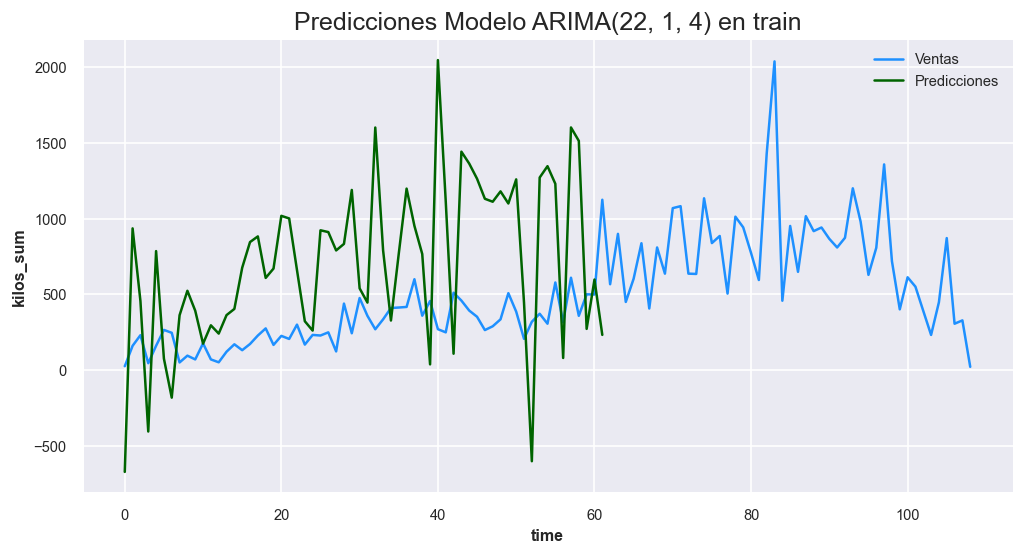

time: 687 ms (started: 2022-03-17 16:25:31 -03:00)


In [413]:
plt.figure(figsize=(10,5))

plt.title('Predicciones Modelo ARIMA(22, 1, 4) en train', size = 15)

sns.lineplot(data = weekly_series['total']['df']['kilos_sum'], label = 'Ventas', color = 'dodgerblue')
sns.lineplot(data = df_results1['pred'], color = 'darkgreen', label = 'Predicciones')
sns.despine();

In [415]:
mean_absolute_percentage_error(train_0[23:], arima_pred)

1.143824659256968

time: 0 ns (started: 2022-03-17 16:25:44 -03:00)


In [416]:
residuals_arima = train_0[23:] - arima_pred
residuals_arima

time
23     841.503041
24    -704.205419
25    -227.790195
26     655.494935
27    -663.009151
         ...     
80    -829.170079
81    -919.720051
82    1158.094575
83    1442.099037
84     225.781646
Name: kilos_sum, Length: 62, dtype: float64

time: 15 ms (started: 2022-03-17 16:25:48 -03:00)


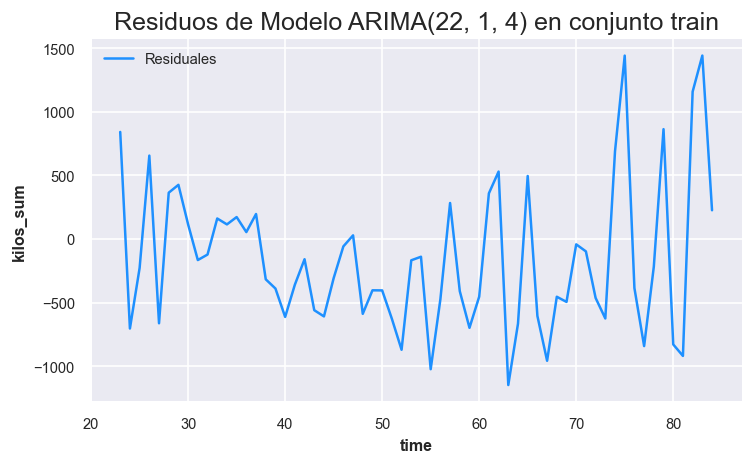

time: 781 ms (started: 2022-03-17 16:25:53 -03:00)


In [417]:
plt.figure(figsize=(7,4))

plt.title('Residuos de Modelo ARIMA(22, 1, 4) en conjunto train', size = 15)

sns.lineplot(data = residuals_arima, label = 'Residuales', color = 'dodgerblue')
sns.despine();

In [418]:
weekly_arimaresid_jb = jarque_bera(residuals_arima)
print('p-value Jarque-Bera train: ', weekly_arimaresid_jb[1], '\nSkew: ', weekly_arimaresid_jb[2], '\nKurtosis: ', weekly_arimaresid_jb[3])

p-value Jarque-Bera train:  0.02389030719909626 
Skew:  0.8286555743109084 
Kurtosis:  3.379969925301564
time: 15 ms (started: 2022-03-17 16:25:58 -03:00)


Los residuos en el conjunto train no tienen una distribución normal para el modelo.

In [425]:
from pmdarima.arima import auto_arima

p_param = [1, 4, 16, 22, 25, 41, 53]
d_param = 1
q_param = [1, 4, 16, 22, 25, 41, 53]

autoarima = auto_arima(weekly_series['total']['df']['kilos_sum'],
                        start_p = 4,
                        d = 1,
                        start_q = 4,
                        max_p = 53,
                        max_d = 1,
                        max_q = 53,
                        trace = True
                        )


Performing stepwise search to minimize aic
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=1494.421, Time=2.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1542.143, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1522.280, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1495.199, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1540.144, Time=0.03 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=3.31 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=1490.818, Time=0.88 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1490.865, Time=0.69 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1495.787, Time=0.78 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=1493.453, Time=0.95 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1494.582, Time=0.43 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=1497.236, Time=0.74 sec
 ARIMA(5,1,4)(0,0,0)[0] intercept   : AIC=1495.815, Time=0.96 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=1488.961, Time=0.68 sec
 ARIMA(3,1,3)(0,0,0)[0]             : 

In [426]:
autoarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  109
Model:               SARIMAX(2, 1, 4)   Log Likelihood                -736.611
Date:                Thu, 17 Mar 2022   AIC                           1487.221
Time:                        16:51:47   BIC                           1505.996
Sample:                             0   HQIC                          1494.834
                                - 109                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3336      0.101     -3.319      0.001      -0.531      -0.137
ar.L2         -0.7727      0.090     -8.628      0.000      -0.948      -0.597
ma.L1         -0.4493      0.108     -4.161      0.000      -0.661      -0.238
ma.L2          0.5471      0.110      4.981      0.000       0.332       0.762
ma.L3         -0.7796      0.078     -9.983      0.000      -0.933      -0.627
ma.L4          0.2898      0.092      3.143      0.002       0.109       0.471
sigma2      4.824e+04   3960.978     12.179      0.000    4.05e+04     5.6e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               128.91
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):              12.90   Skew:                             0.99
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

time: 47 ms (started: 2022-03-17 16:51:47 -03:00)


In [ ]:
# no terminado
#---------------

#iteración para crear las tuplas de parámetros a revisar

import itertools

params_set = []

p_param = [1, 4, 16, 22, 25, 41, 53]
d_param = 1
q_param = [1, 4, 16, 22, 25, 41, 53]

for i in p_param:
    for j in q_param:
        params_set.append((i, d_param, j))

print(params_set)
print(f"Cantidad de combinaciones de parámetros: {len(params_set)}")

#rolling predictions para modelo ARIMA sobre test: últimas 24 semanas

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error

#definición de tamaño fijo de conjuntos train y test, considerando que el total de datos = 109 semanas
len_train = 85
len_test = 24
mape_test = []
jb_resid_test = []
mape_train = []
jb_resid_train = []

def arima_analysis(params_set):
    #lista que contiene resultados

    for i in params_set:

        #parte 1: análisis sobre conjunto test
        #loop para la creación del conjunto de entrenamiento, modelación y rolling prediction

        for j in range(len_test):
            arima_pred = []
            train = weekly_series['total']['df']['kilos_sum'][:-(len_test - j)]
            #res = STL(train, period = 16).fit() #
            #train_des = train 
            arima = ARIMA(train, order = i)
            arima_fit = arima.fit()
            arima_preds = arima_fit.forecast(steps = 1)

            #guardado de resultados
            arima_pred.append(arima_preds.values[0])

            #hay que hacer esto?
            #arima_preds = pd.DataFrame(arima_pred, columns = ['kilos_sum'])
            #arima_preds.index = test_0.values

            #cálculo de métrica sobre test
            mape_result_test = mean_absolute_percentage_error(test_0, arima_pred)

            #residuales
            residuals_arima_test = test_0 - arima_pred

            #evaluación de normalidad de residuos
            weekly_arimaresid_jb_test = jarque_bera(residuals_arima_test)
            print('p-value Jarque-Bera test: ', weekly_arimaresid_jb[1], '\nSkew: ', weekly_arimaresid_jb[2], '\nKurtosis: ', weekly_arimaresid_jb[3])

        #parte 2: análisis sobre conjunto train
        #loop para la creación del conjunto de entrenamiento, modelación y rolling prediction

        for j in range(16, len_train):
            arima_pred = []
            train = weekly_series['total']['df']['kilos_sum'][:-(len_train - j)]
            #res = STL(train, period = 16).fit() #
            #train_des = train#
            arima = ARIMA(train, order = i)
            arima_fit = arima.fit()
            arima_preds = arima_fit.forecast(steps = 1)

            #guardado de resultados
            arima_pred.append(arima_preds.values[0])

            #omitir
            #arima_preds = pd.DataFrame(arima_pred, columns = ['kilos_sum'])
            #arima_preds.index = train_0.values[16:]

            #cálculo de métrica sobre test
            mape_result_train = mean_absolute_percentage_error(train_0, arima_pred)

            #residuales
            residuals_arima_train = test_0 - arima_pred

            #evaluación de normalidad de residuos
            weekly_arimaresid_jb_train = jarque_bera(residuals_arima_train)
            print('p-value Jarque-Bera test: ', weekly_arimaresid_jb[1], '\nSkew: ', weekly_arimaresid_jb[2], '\nKurtosis: ', weekly_arimaresid_jb[3])

        mape_test.append(mape_result_test)
        jb_resid_test.append(weekly_arimaresid_jb_test)
        mape_train.append(mape_result_train)
        jb_resid_train.append(weekly_arimaresid_jb_train)